<a href="https://colab.research.google.com/github/Jugranada/Aprendizaje_Maquina/blob/main/Parcial_1_TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Ejercicio 1**

Sea el modelo de regresión:

$[
t_n = \phi(x_n) w^\top + \eta_n,
]$

con

$[
\{ t_n \in \mathbb{R}, \; x_n \in \mathbb{R}^P \}_{n=1}^N, \quad
w \in \mathbb{R}^Q, \quad
\phi : \mathbb{R}^P \rightarrow \mathbb{R}^Q, \quad Q \geq P,
]$
y

$[
\eta_n \sim \mathcal{N}(\eta_n | 0, \sigma_\eta^2).
]$

---

##  Objetivo

Presente el **problema de optimización** y la **solución analítica** para los siguientes modelos de regresión:

1. **Mínimos Cuadrados Ordinarios (OLS)**  
2. **Mínimos Cuadrados Regularizados (Ridge)**  
3. **Máxima Verosimilitud (ML)**  
4. **Máximo a Posteriori (MAP)**  
5. **Regresión Bayesiana con modelo lineal Gaussiano**  
6. **Regresión Rígida Kernel (Kernel Ridge Regression)**  
7. **Regresión mediante Procesos Gaussianos (Gaussian Processes)**  


##  **Generacion de Datos**

el modelo de señal se define como:

$[
t^*(x) = A \sin(2\pi F_0 x)
]$

donde:
- $( A )$ es la amplitud de la señal,
- $( F_0 )$ es la frecuencia fundamental,
- $( x )$ es el vector de muestras en el tiempo.

La señal observada se obtiene como:

$[
t(x) = t^*(x) + \eta(x)
]$

donde el término de ruido $( \eta(x) )$ es un proceso aleatorio gaussiano con varianza determinada por el SNR deseado:

$[
\sigma_\eta^2 = \frac{P_x}{10^{\frac{\text{SNR}_{dB}}{10}}}
]$

con $( P_x = \mathbb{E}[t^*(x)^2] )$ siendo la potencia promedio de la señal limpia.

---

1. **Cálculo de la varianza del ruido (`var_snr`)**  
   Se implementa una función auxiliar que recibe la señal limpia $( x )$ y el valor de SNR en decibelios, y devuelve la varianza del ruido necesaria para lograr dicha relación:
   $[
   \text{var_snr}(x, \text{SNR}_{dB}) = \frac{\mathbb{E}[x^2]}{10^{\frac{\text{SNR}_{dB}}{10}}}
   ]$
   Esto garantiza que el ruido añadido mantenga la proporción de energía especificada.

2. **Parámetros de la señal**  
   Se fija una frecuencia fundamental $( F_0 = 60\,\text{Hz} )$, una amplitud $( A = 10 )$, y una frecuencia de muestreo $( F_s = 100 F_0 )$ (satisfaciendo ampliamente el criterio de Nyquist).  
   El período de la señal es $( T_0 = \frac{1}{F_0} )$, y el vector de tiempo se genera como:
   $[
   X = \{0, \tfrac{1}{F_s}, \tfrac{2}{F_s}, \dots, T_0 - \tfrac{1}{F_s}\}
   ]$

3. **Generación de la señal limpia**  
   Se obtiene la señal base senoidal:
   $[
   t^*(x) = A \sin(2\pi F_0 x)
   ]$

4. **Adición de ruido gaussiano**  
   A la señal limpia se le suma un término de ruido blanco gaussiano de varianza calculada mediante la función `var_snr()`:
   $[
   t(x) = t^*(x) + \sqrt{\sigma_\eta^2}\, \mathcal{N}(0,1)
   ]$
   donde $( \mathcal{N}(0,1) )$ representa una variable aleatoria normal estándar.

5. **Ajuste de dimensiones**  
   Los vectores $( X )$ y $( t )$ se remodelan a formato columna (`(n_muestras, 1)`), lo cual facilita su uso en los modelos posteriores.

6. **Visualización de los datos**  
   Se grafica la señal limpia en color rojo y la señal ruidosa mediante puntos azules.  
   Esto permite observar visualmente el efecto del ruido y verificar la correcta simulación de los datos.
---


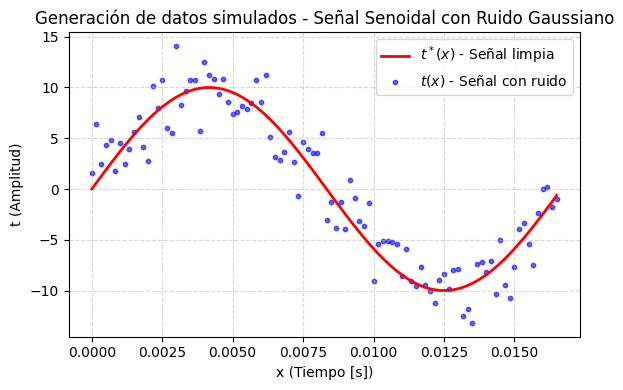

In [2]:
# ============================================================
# PREPARACIÓN DE DATOS COMUNES
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Función: cálculo de la varianza del ruido a partir del SNR en dB
# Entradas:
#   x: vector de datos (señal limpia)
#   snrdB: relación señal-ruido en decibelios (SNR[dB])
# Salida:
#   varianza del ruido necesaria para alcanzar el SNR especificado
# ------------------------------------------------------------
def var_snr(x, snrdB):
    Px = np.mean(x**2)                   # Potencia media de la señal
    Pn = Px / (10**(snrdB/10))           # Potencia del ruido a partir del SNR
    return Pn                            # Devuelve la varianza del ruido

# ------------------------------------------------------------
# Parámetros del modelo de señal
# ------------------------------------------------------------
Fo = 60                 # Frecuencia fundamental [Hz]
A = 10                  # Amplitud de la señal
To = 1/Fo               # Período fundamental [s]
Fs = 100 * Fo           # Frecuencia de muestreo (100x la fundamental)
snrdB = 10              # Relación señal-ruido en decibelios (SNR[dB])

# ------------------------------------------------------------
# Vector de entrada y generación de señal
# ------------------------------------------------------------
X = np.arange(0, To, 1/Fs)               # Vector de tiempo dentro de un período
tt = A * np.sin(2*np.pi*Fo*X)            # Señal limpia (objetivo teórico)

# ------------------------------------------------------------
# Generación de señal ruidosa (ruido blanco Gaussiano)
# ------------------------------------------------------------
var_noise = var_snr(tt, snrdB)           # Varianza del ruido según el SNR
t = tt + np.sqrt(var_noise) * np.random.randn(len(X))  # Señal contaminada

# ------------------------------------------------------------
# Ajuste de dimensiones (n muestras x 1 característica)
# ------------------------------------------------------------
X = X.reshape(-1, 1)                     # Vector de entrada como columna
t = t.reshape(-1, 1)                     # Vector de salida como columna

# ------------------------------------------------------------
# Visualización de los datos simulados
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(X, tt, c='r', linewidth=2, label='$t^*(x)$ - Señal limpia')
plt.scatter(X, t, c='b', s=10, alpha=0.6, label='$t(x)$ - Señal con ruido')
plt.title('Generación de datos simulados - Señal Senoidal con Ruido Gaussiano')
plt.xlabel('x (Tiempo [s])')
plt.ylabel('t (Amplitud)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Nota:
# Los vectores X y t generados aquí serán utilizados por todos
# los modelos (OLS, Ridge, ML, MAP, Bayesiano, Kernel Ridge, GP)
# ------------------------------------------------------------


###  **Mínimos Cuadrados Ordinarios (OLS)**

El modelo lineal base se define como:

$[
t_n = \boldsymbol{\phi}(\mathbf{x}_n)^\top \mathbf{w} + \eta_n,
]$

donde:
- $( t_n \in \mathbb{R} )$ es la salida observada,
- $( \mathbf{x}_n \in \mathbb{R}^P )$ es la entrada,
- $( \boldsymbol{\phi}(\mathbf{x}_n) \in \mathbb{R}^Q )$ es la representación del vector de características (por ejemplo, polinómica),
- $( \eta_n \sim \mathcal{N}(0, \sigma_\eta^2) )$ es el ruido Gaussiano aditivo,
- y $( \mathbf{w} \in \mathbb{R}^Q )$ son los pesos del modelo a estimar.

---

####  Formulación matricial

Apilando las observaciones en forma matricial:

$[
\mathbf{t} = \Phi \mathbf{w} + \boldsymbol{\eta},
]$

donde:
- $(\Phi = [\boldsymbol{\phi}(\mathbf{x}_1)^\top, \dots, \boldsymbol{\phi}(\mathbf{x}_N)^\top]^\top \in \mathbb{R}^{N \times Q})$,
- $(\mathbf{t} = [t_1, \dots, t_N]^\top \in \mathbb{R}^{N})$.

---

####  Implementación

En el código, la matriz de diseño $(\Phi)$ se genera mediante `PolynomialFeatures`, que expande los datos $(X)$ hasta grado $(Q)$

El modelo se entrena con `LinearRegression(fit_intercept=False)`, que internamente implementa la solución anterior

$[
\texttt{LinearRegression} \; \Rightarrow \; \mathbf{w}_{OLS} = (\Phi^\top \Phi)^{-1} \Phi^\top \mathbf{t}.
]$

---

#### 📈 Predicción y visualización

Las predicciones para las muestras de prueba se calculan como:

$[
\hat{\mathbf{t}} = \Phi_{\text{test}} \, \mathbf{w}_{OLS}.
]$

En la gráfica se comparan:
- $(t^*(x))$: la señal real sin ruido,
- $(t(x))$: los datos observados con ruido,
- $(\hat{t}(x))$: la predicción del modelo OLS.

---


Partición 1: 80 train, 20 test


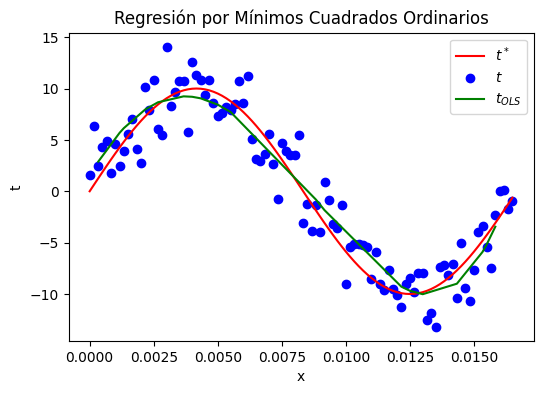

In [3]:
# ==============================================================
#  MÍNIMOS CUADRADOS ORDINARIOS (OLS)
# ==============================================================
# Modelo: t = Φw^T + η ,   con w_ML = (Φ^T Φ)^(-1) Φ^T t
# Implementación mediante sklearn.linear_model.LinearRegression
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# --------------------------------------------------------------
# 1. Generación de la representación polinomial Φ(x)
# --------------------------------------------------------------
Q = 4  # grado del polinomio -> define dimensión Q de Φ(x)
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)  # Φ ∈ R^{N x (Q+1)}

# --------------------------------------------------------------
# 2. División del conjunto de datos (train / test)
# --------------------------------------------------------------
# Usamos ShuffleSplit para obtener índices aleatorios reproducibles
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)

for i, (train_i, test_i) in enumerate(rs.split(X)):
    print(f"Partición {i+1}: {len(train_i)} train, {len(test_i)} test")

train_i = np.sort(train_i)
test_i = np.sort(test_i)

# --------------------------------------------------------------
# 3. Definición y entrenamiento del modelo lineal
# --------------------------------------------------------------
# LinearRegression implementa internamente la solución cerrada:
# w_OLS = (Φ^T Φ)^(-1) Φ^T t
reg_ols = LinearRegression(fit_intercept=False)
# (fit_intercept=False porque el término independiente ya está incluido en Φ)

reg_ols.fit(Phi[train_i], t[train_i])  # estimación de w_OLS

# --------------------------------------------------------------
# 4. Predicción sobre el conjunto de test
# --------------------------------------------------------------
t_ols = reg_ols.predict(Phi[test_i])  # t̂ = Φ w_OLS^T

# --------------------------------------------------------------
# 5. Visualización de resultados
# --------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(X, tt, c='r', label='$t^*$')            # señal real (sin ruido)
plt.scatter(X, t, c='b', label='$t$')            # muestras con ruido
plt.plot(X[test_i], t_ols, c='g', label='$t_{OLS}$')  # estimación modelo OLS
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Regresión por Mínimos Cuadrados Ordinarios')
plt.show()

# --------------------------------------------------------------
# 6. Comentario teórico
# --------------------------------------------------------------
# En este bloque, sklearn resuelve el sistema normal:
#     (Φ^T Φ) w = Φ^T t
# Su solución analítica (cerrada) es:
#     w_OLS = (Φ^T Φ)^(-1) Φ^T t
# La predicción resultante:
#     t̂ = Φ w_OLS^T
# corresponde al estimador de mínima varianza insesgado bajo
# la hipótesis de ruido blanco Gaussiano η ~ N(0, σ_η²)


###  **Mínimos Cuadrados Regularizados (Ridge Regression)**

En este modelo se busca mitigar el problema de **sobreajuste** y la **inestabilidad numérica** que puede aparecer en la regresión por mínimos cuadrados ordinarios (OLS), especialmente cuando las variables predictoras están altamente correlacionadas o la matriz de diseño $(\Phi^\top \Phi)$ es mal condicionada.  

La función objetivo en Ridge incluye un término de **penalización L2** sobre los coeficientes $(w)$, controlado por un parámetro de regularización $(\lambda)$:

$[
E(\mathbf{w}) = \frac{1}{2N}\|\mathbf{t} - \Phi \mathbf{w}\|^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2
]$

donde:
- $(\mathbf{t})$ es el vector de valores observados.
- $(\Phi)$ es la matriz de diseño (las bases polinómicas de los datos de entrada).
- $(\mathbf{w})$ son los coeficientes del modelo.
- $(\lambda)$ controla el grado de regularización:  
  - Si $(\lambda \to 0)$, el modelo se aproxima a OLS.  
  - Si $(\lambda \to \infty)$, los pesos tienden a cero, y el modelo se vuelve muy suave.

La **solución cerrada** del modelo Ridge es:

$[
\mathbf{w}_{ridge} = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top \mathbf{t}
]$

---

####  Implementación en código

En el bloque de código se siguen los siguientes pasos:

1. **Construcción de la matriz de diseño**
   Se utiliza `PolynomialFeatures` para crear las columnas de la matriz $(\Phi)$ correspondientes a las potencias de $(x)$, es decir:
   $[
   \Phi = [1, x, x^2, x^3, \dots, x^M]
   ]$
   con $(M)$ el grado del polinomio elegido.

3. **Ajuste del modelo Ridge**
   Se utiliza el método `Ridge()` de `scikit-learn`, que internamente implementa la solución analítica anterior.  
   El parámetro `alpha` corresponde directamente a $(\lambda)$:
   ```python
   reg_ridge = Ridge(alpha=lambdaR, fit_intercept=False)
   reg_ridge.fit(Phi, t)


División 1 realizada.


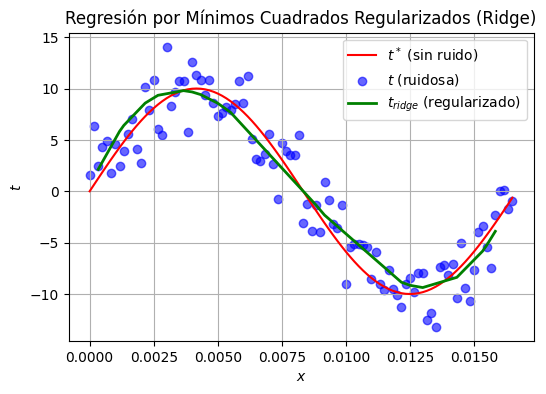

In [4]:
# ============================================================
#  MÍNIMOS CUADRADOS REGULARIZADOS (RIDGE)
# ============================================================

# En este modelo, se añade un término de regularización L2 al error cuadrático.
# La función de costo es:
#     E(w) = (1/2) ||t - Φw||^2 + (λ/2) ||w||^2
# Su solución cerrada es:
#     w_ridge = (ΦᵀΦ + λI)⁻¹ Φᵀt

from sklearn.linear_model import Ridge             # Modelo Ridge (regularización L2)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1) Representación polinómica de las entradas
# ------------------------------------------------------------

Q = 4  # Grado del polinomio (mismo que en OLS para comparación)
phiQ = PolynomialFeatures(degree=Q)  # Crea las funciones base polinómicas ϕ(x)
Phi = phiQ.fit_transform(X)           # Aplica la transformación → matriz Φ

# ------------------------------------------------------------
# 2) División de los datos en entrenamiento y prueba
# ------------------------------------------------------------

rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)  # partición aleatoria (20% test)
for i, (train_i, test_i) in enumerate(rs.split(X)):            # devuelve índices train/test
    print(f"División {i+1} realizada.")

# Ordenar los índices (para graficar en orden)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

# ------------------------------------------------------------
# 3) Definición del modelo Ridge (mínimos cuadrados regularizados)
# ------------------------------------------------------------

lambdaR = 1e-14  # λ = parámetro de regularización
# En la teoría: (ΦᵀΦ + λI)⁻¹Φᵀt  ⇒ penaliza grandes valores de w para evitar sobreajuste
reg_ridge = Ridge(alpha=lambdaR, fit_intercept=False)

# ------------------------------------------------------------
# 4) Entrenamiento del modelo
# ------------------------------------------------------------

# Ajustar el modelo con los datos de entrenamiento
reg_ridge.fit(Phi[train_i], t[train_i])

# ------------------------------------------------------------
# 5) Predicción sobre los datos de prueba
# ------------------------------------------------------------

t_ridge = reg_ridge.predict(Phi[test_i])  # salida predicha t̂ = Φ_test w_ridge

# ------------------------------------------------------------
# 6) Visualización de resultados
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(X, tt, c='r', label='$t^*$ (sin ruido)')         # señal real
plt.scatter(X, t, c='b', label='$t$ (ruidosa)', alpha=0.6) # datos observados
plt.plot(X[test_i], t_ridge, c='g', lw=2, label='$t_{ridge}$ (regularizado)')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Regresión por Mínimos Cuadrados Regularizados (Ridge)')
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# Comentario final:
# ------------------------------------------------------------
# A diferencia del OLS, este modelo introduce λ||w||² en la función de costo,
# lo que "encoge" los coeficientes y reduce la varianza del modelo.
# La solución teórica corresponde a:
#     w_ridge = (ΦᵀΦ + λI)⁻¹ Φᵀt
# donde λ controla el compromiso entre ajuste y suavidad.


### **Máxima Verosimilitud (ML)**

---

###  Fundamento teórico

El método de **Máxima Verosimilitud (Maximum Likelihood, ML)** busca estimar los parámetros de un modelo probabilístico que **maximicen la probabilidad de observar los datos medidos**.  
En el caso de una regresión lineal con ruido gaussiano, se asume que:

$[
t_n = \phi(x_n)^\top w + \eta_n, \quad \eta_n \sim \mathcal{N}(0, \sigma^2)
]$

donde:
- $( t_n )$ son las observaciones (valores medidos),
- $( \phi(x_n) )$ son las funciones base o entradas polinómicas,
- $( w )$ son los coeficientes del modelo,
- $( \eta_n )$ es el ruido gaussiano con varianza \( \sigma^2 \).

---

###  Función de verosimilitud

Dado el conjunto de observaciones $( \{t_n\} )$, la **verosimilitud** del modelo está dada por:

$[
p(t | X, w, \sigma^2) = \prod_{n=1}^{N} \mathcal{N}(t_n | \phi(x_n)^\top w, \sigma^2)
]$

El logaritmo de la verosimilitud (log-verosimilitud) es:

$[
\ln p(t|X, w, \sigma^2) = -\frac{N}{2}\ln(2\pi\sigma^2)
 - \frac{1}{2\sigma^2} \sum_{n=1}^{N}(t_n - \phi(x_n)^\top w)^2
]$

---

###  Estimadores por ML

Para obtener las estimaciones de los parámetros, se maximizan las ecuaciones anteriores respecto a $( w )$ y $( \sigma^2 )$.

- **Estimador de los pesos $( w_{ML} )$:**
  $[
  w_{ML} = (\Phi^\top \Phi)^{-1} \Phi^\top t
  ]$
  que corresponde exactamente al estimador de **Mínimos Cuadrados Ordinarios (OLS)**.

- **Estimador de la varianza $( \sigma^2_{ML} )$:**
  $[
  \hat{\sigma}^2_{ML} = \frac{1}{N}\sum_{n=1}^{N}(t_n - \phi(x_n)^\top w_{ML})^2
  ]$

---


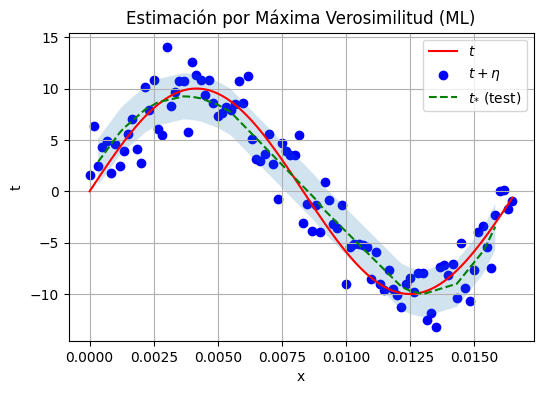

Varianza estimada (σ²_ML): 5.074932135702188


In [5]:
# ------------------------------------------------------------
# predictiva ML
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# asumimos que el modelo OLS entrenado se llama reg_ols (análogo a reg_mc)
# y que Phi, train_i, test_i, X, t, tt ya existen en el entorno

# 1) calcular varianza ML a partir de los residuos en TRAIN
# convertir a vectores 1D para evitar problemas de shape
res_train = t[train_i].ravel() - reg_ols.predict(Phi[train_i]).ravel()
var_ml = (np.linalg.norm(res_train)**2) / len(res_train)

# 2) predicción en TEST
t_mc = reg_ols.predict(Phi[test_i]).ravel()   # vector 1D de predicciones en test

# 3) ordenar los puntos de test por X para que la línea no haga zig-zag
order = np.argsort(X[test_i].ravel())
X_test_sorted = X[test_i].ravel()[order]
t_mc_sorted = t_mc[order]


# 4) gráfica
plt.figure(figsize=(6,4))
plt.plot(X, tt, c='r', label='$t$')                      # señal limpia
plt.scatter(X, t, c='b', label='$t+\\eta$')              # datos ruidosos

# también dibujamos la predicción solamente en test (idéntico al ejemplo)
plt.plot(X_test_sorted, t_mc_sorted, c='g', linestyle='--', label='$t_{*}$ (test)')

# banda de incertidumbre alrededor de la predicción en TEST (misma sintaxis que el ejemplo)
plt.fill_between(
    X_test_sorted,
    t_mc_sorted - np.sqrt(var_ml) * np.ones(len(t_mc_sorted)),
    t_mc_sorted + np.sqrt(var_ml) * np.ones(len(t_mc_sorted)),
    alpha=0.2
)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Estimación por Máxima Verosimilitud (ML)')
plt.grid(True)
plt.show()

print("Varianza estimada (σ²_ML):", var_ml)


#### **MÁXIMO A POSTERIORI (MAP)**

En este bloque implementamos la **estimación por Máximo a Posteriori (MAP)**, un método
de inferencia bayesiana que permite encontrar los pesos más probables del modelo
dadas las observaciones ruidosas.

---

###  Fundamento teórico

En un modelo de regresión lineal con ruido gaussiano, la relación entre las variables se describe como:

$[
t = \Phi w + \eta
]$
donde:
- $( t )$ son las observaciones (valores medidos),
- $( \Phi )$ es la matriz de diseño (bases polinómicas o funciones de entrada),
- $( w )$ es el vector de pesos del modelo,
- $( \eta \sim \mathcal{N}(0, \sigma_\eta^2 I) )$ es el ruido gaussiano.

A diferencia de los mínimos cuadrados ordinarios (OLS), el modelo **MAP** introduce
una **distribución a priori sobre los pesos** del modelo, también gaussiana:

$[
p(w) = \mathcal{N}(0, \sigma_w^2 I)
]$

La estimación MAP se obtiene aplicando el **Teorema de Bayes**:

$[
p(w|t) \propto p(t|w) \, p(w)
]$

Maximizar esta probabilidad equivale a minimizar la siguiente función de costo:

$[
E(w) = \frac{1}{2\sigma_\eta^2} \| t - \Phi w \|^2 + \frac{1}{2\sigma_w^2} \| w \|^2
]$

---

### Solución analítica

Derivando respecto a $( w )$ y anulando el gradiente:

$[
\frac{\partial E(w)}{\partial w} = 0
\quad \Rightarrow \quad
w_{MAP} = (\Phi^T \Phi + \lambda I)^{-1} \Phi^T t
]$

donde el parámetro de regularización **λ** surge de la relación entre las varianzas:

$[
\lambda = \frac{\sigma_\eta^2}{\sigma_w^2}
]$

Esta expresión es **idéntica a la de Ridge Regression**, pero aquí **λ tiene interpretación probabilística**.

---

### Varianza predictiva

La incertidumbre sobre una predicción $( t_* )$ para una nueva entrada $( \Phi_* )$ se estima como:

$[
\mathrm{Var}[t_*] = \sigma_\eta^2 + \Phi_* (\Phi^T \Phi + \lambda I)^{-1} \Phi_*^T
]$

En la práctica, se puede aproximar esta varianza mediante el error cuadrático medio en el conjunto de entrenamiento:

$[
\sigma_{MAP}^2 = \frac{1}{N_{train}} \| t_{train} - \Phi_{train} w_{MAP} \|^2
]$

Esta varianza define la **banda de incertidumbre ±σ** que se muestra en la gráfica.

---

λ (MAP) = 1.00e-14


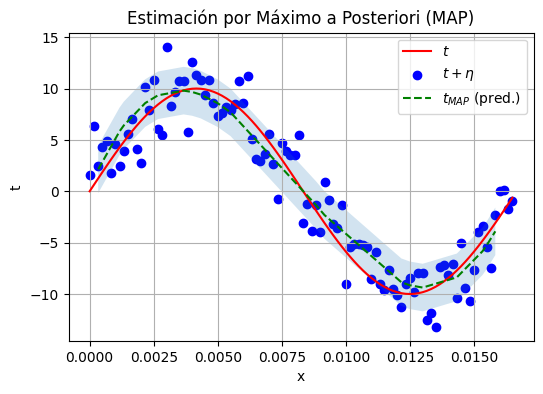

Varianza estimada (σ²_MAP): 5.357218440890712


In [6]:
# ============================================================
#  MÁXIMO A POSTERIORI (MAP)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Definición de hiperparámetros del modelo
# ------------------------------------------------------------
sigma_eta = 0.1        # desviación estándar del ruido observado
sigma_w   = 1.0        # desviación estándar del prior sobre los pesos
lambda_map = 1e-14     # λ ≈ σ_η² / σ_w²  (valor pequeño para no sobre-regularizar)

print(f"λ (MAP) = {lambda_map:.2e}")

# ------------------------------------------------------------
# 2) Cálculo de los pesos w_MAP (solución cerrada)
# ------------------------------------------------------------
I = np.eye(Phi.shape[1])
A = Phi[train_i].T @ Phi[train_i] + lambda_map * I
b = Phi[train_i].T @ t[train_i]
w_map = np.linalg.solve(A, b)

# ------------------------------------------------------------
# 3) Predicción sobre el conjunto de prueba
# ------------------------------------------------------------
Phi_test = Phi[test_i]
t_map = Phi_test @ w_map  # predicción MAP en test

# ------------------------------------------------------------
# 4) Cálculo de la varianza predictiva (similar a ML)
# ------------------------------------------------------------
# Estimamos la varianza a partir del error en entrenamiento:
res_train_map = t[train_i].ravel() - (Phi[train_i] @ w_map).ravel()
var_map = (np.linalg.norm(res_train_map)**2) / len(res_train_map)

# Ordenar para graficar
order = np.argsort(X[test_i].ravel())
X_test_sorted = X[test_i].ravel()[order]
t_map_sorted = t_map.ravel()[order]

# ------------------------------------------------------------
# 5) Gráfica
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(X, tt, c='r', label='$t$')                      # señal real
plt.scatter(X, t, c='b', label='$t+\\eta$')              # datos con ruido
plt.plot(X_test_sorted, t_map_sorted, c='g', linestyle='--', label='$t_{MAP}$ (pred.)')

# Banda de incertidumbre con varianza MAP (misma sintaxis que el ejemplo ML)
plt.fill_between(
    X_test_sorted,
    t_map_sorted - np.sqrt(var_map) * np.ones(len(t_map_sorted)),
    t_map_sorted + np.sqrt(var_map) * np.ones(len(t_map_sorted)),
    alpha=0.2
)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Estimación por Máximo a Posteriori (MAP)')
plt.grid(True)
plt.show()

print("Varianza estimada (σ²_MAP):", var_map)


### **Modelo Bayesiano — Regresión Lineal Gaussiana**

En este modelo adoptamos un enfoque **totalmente Bayesiano** para la regresión lineal.  
A diferencia de los métodos de **Máxima Verosimilitud (ML)** o **Máximo a Posteriori (MAP)**, donde estimamos un conjunto fijo de pesos, aquí tratamos los **pesos** `w` como una **variable aleatoria** con una distribución Gaussiana, y calculamos su **distribución posterior completa**.

---

###  Fundamento teórico

###  Modelo generativo

La relación entre las entradas y las salidas se modela como:
$[
t_n = \phi(\mathbf{x}_n)^\top \mathbf{w} + \eta_n
]$
donde:
- $( \phi(\mathbf{x}_n) )$ es el vector de características o base polinomial,
- $( \eta_n \sim \mathscr{N}(0, \sigma_\eta^2) )$ es ruido blanco Gaussiano con varianza $( \sigma_\eta^2 )$,
- $( \mathbf{w} )$ son los pesos del modelo.

Por tanto, la **verosimilitud** de todos los datos se escribe como:
$[
p(\mathbf{t}|\mathbf{w}) = \mathscr{N}(\mathbf{t}|\Phi \mathbf{w}, \sigma_\eta^2 \mathbf{I})
]$

donde $( \Phi )$ es la **matriz de diseño** formada por todas las $( \phi(\mathbf{x}_n) )$.

---

###  Prior sobre los pesos

Imponemos un prior Gaussiano:
$[
p(\mathbf{w}) = \mathscr{N}(\mathbf{w}|\mathbf{m}_0, \mathbf{S}_0)
]$

En el caso más simple:
$[
p(\mathbf{w}) = \mathscr{N}(\mathbf{w}|0, \sigma_w^2 \mathbf{I})
]$
donde $( \sigma_w^2 )$ representa la incertidumbre inicial (cuánto creemos que pueden variar los pesos).

---

###  Distribución posterior

Usando el teorema de Bayes, la **posterior** sobre los pesos también es Gaussiana:

$[
p(\mathbf{w}|\mathbf{t}) = \mathscr{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)
]$

con:
$[
\mathbf{S}_N = \left(\frac{1}{\sigma_w^2}\mathbf{I} + \frac{1}{\sigma_\eta^2}\Phi^\top \Phi\right)^{-1}
]$

$[
\mathbf{m}_N = \frac{1}{\sigma_\eta^2}\mathbf{S}_N \Phi^\top \mathbf{t}
]$

donde:
- $( \mathbf{m}_N )$: media posterior (equivalente a los pesos estimados),
- $( \mathbf{S}_N )$: covarianza posterior (incertidumbre sobre los pesos).

**Nota:** la media $( \mathbf{m}_N )$ es equivalente a la solución de **Ridge Regression** o **MAP**, pero ahora también tenemos una **distribución de incertidumbre** (la matriz $( \mathbf{S}_N ))$.

---

###  Distribución predictiva

Para un nuevo dato $( \mathbf{x}_* )$, la salida $( t_* )$ también sigue una distribución Gaussiana:

$[
p(t_*|\mathbf{x}_*,\mathbf{t}) = \mathscr{N}(t_*|\phi(\mathbf{x}_*)^\top \mathbf{m}_N, \sigma_\eta^2 + \phi(\mathbf{x}_*)^\top \mathbf{S}_N \phi(\mathbf{x}_*))
]$

- La **media predictiva** $( \phi(\mathbf{x}_*)^\top \mathbf{m}_N )$ da la mejor estimación de $( t_* )$.
- La **varianza predictiva**
  $[
  \text{Var}[t_*] = \sigma_\eta^2 + \phi(\mathbf{x}_*)^\top \mathbf{S}_N \phi(\mathbf{x}_*)
  ]$
  refleja tanto el ruido del modelo como la incertidumbre en los pesos.

---

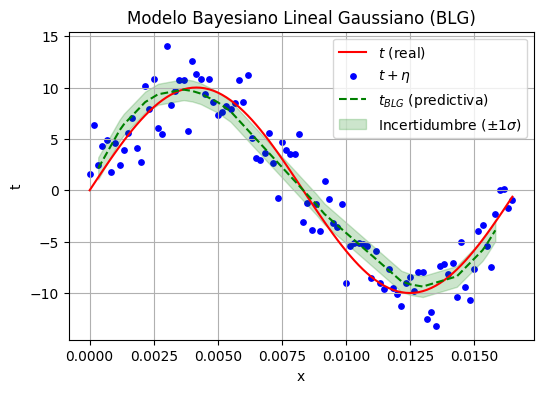

Media posterior mN shape: (10, 1)
Covarianza posterior SN shape: (10, 10)


In [7]:
# ============================================================
#  MODELO BAYESIANO LINEAL GAUSSIANO (BLG)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# ------------------------------------------------------------
# 1) Función: estimar parámetros posteriores (m_N, S_N)
# ------------------------------------------------------------
def my_linGaussiano(X, t, phiQ, sigma_eta, sigma_w, tol=1e-16):
    """
    Calcula la media (mN) y covarianza (SN) del posterior en el modelo lineal gaussiano.
    Args:
        X: datos de entrada (N x 1)
        t: salidas observadas (N x 1)
        phiQ: transformador de características (PolynomialFeatures)
        sigma_eta: desviación estándar del ruido
        sigma_w: desviación estándar del prior de los pesos
        tol: umbral para evitar problemas numéricos
    """
    # Matriz de diseño Φ (N x Q)
    Phi = phiQ.fit_transform(X)

    # Relación de regularización λ = σ_η² / σ_w²
    lambdaR = (sigma_eta**2) / (sigma_w**2)

    # Inversa de la covarianza posterior (S_N⁻¹)
    SNinv = (1 / sigma_eta**2) * (Phi.T @ Phi) + (1 / sigma_w**2) * np.eye(Phi.shape[1])

    # Descomposición espectral para estabilidad numérica
    val, vec = np.linalg.eigh(SNinv)
    ind = val > tol  # filtra valores propios muy pequeños
    SN = vec[:, ind] @ np.diag(1 / val[ind]) @ vec[:, ind].T  # covarianza posterior

    # Media posterior m_N
    mN = (1 / sigma_eta**2) * SN @ Phi.T @ t

    return mN, SN, val

# ------------------------------------------------------------
# 2) Función: predicción bayesiana
# ------------------------------------------------------------
def my_predictivaLG(Xnew, phiQ, mN, SN, sigma_eta):
    """
    Calcula la media y varianza predictiva para nuevas entradas.
    Args:
        Xnew: nuevos datos (N* x 1)
        phiQ: transformador de características (PolynomialFeatures)
        mN: media posterior de los pesos
        SN: covarianza posterior de los pesos
        sigma_eta: desviación estándar del ruido
    """
    # Matriz Φ para los nuevos puntos
    Phi_new = phiQ.fit_transform(Xnew)

    # Media predictiva: E[t*] = Φ* m_N
    mean_pred = Phi_new @ mN

    # Varianza predictiva: Var[t*] = σ_η² + Φ* S_N Φ*ᵀ
    var_pred = sigma_eta**2 + np.sum(Phi_new @ SN * Phi_new, axis=1)

    return mean_pred, var_pred

# ------------------------------------------------------------
# 3) Datos de ejemplo (ya definidos)
# ------------------------------------------------------------
# Se asume que tienes X, t y tt como en los modelos anteriores

# Grado del polinomio
Q = 9
phiQ = PolynomialFeatures(degree=Q)

# División entrenamiento/prueba
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    train_i = np.sort(train_i)
    test_i = np.sort(test_i)

# ------------------------------------------------------------
# 4) Entrenamiento del modelo Bayesiano Lineal Gaussiano
# ------------------------------------------------------------
sigma_eta = 1.0     # desviación estándar del ruido
sigma_w = 1e7       # prior amplio sobre los pesos (menos regularización)

# Estimación del posterior
mN, SN, val = my_linGaussiano(X[train_i], t[train_i], phiQ, sigma_eta, sigma_w)

# ------------------------------------------------------------
# 5) Predicción sobre el conjunto de prueba
# ------------------------------------------------------------
mean_pred, var_pred = my_predictivaLG(X[test_i], phiQ, mN, SN, sigma_eta)

# Ordenar para graficar
order = np.argsort(X[test_i].ravel())
X_test_sorted = X[test_i].ravel()[order]
mean_sorted = mean_pred.ravel()[order]
std_sorted = np.sqrt(var_pred[order])

# ------------------------------------------------------------
# 6) Gráfica del modelo predictivo
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(X, tt, 'r', label='$t$ (real)')                # señal real
plt.scatter(X, t, color='b', s=15, label='$t + \\eta$') # datos con ruido
plt.plot(X_test_sorted, mean_sorted, 'g--', label='$t_{BLG}$ (predictiva)')

# Banda de incertidumbre bayesiana
plt.fill_between(
    X_test_sorted,
    mean_sorted - std_sorted,
    mean_sorted + std_sorted,
    color='green',
    alpha=0.2,
    label='Incertidumbre ($\\pm 1\\sigma$)'
)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Modelo Bayesiano Lineal Gaussiano (BLG)')
plt.grid(True)
plt.show()

print(f"Media posterior mN shape: {mN.shape}")
print(f"Covarianza posterior SN shape: {SN.shape}")


### **Regresión Ridge con Kernel (KRR)**

### Resumen del modelo

La **Kernel Ridge Regression (KRR)** combina la idea de la regresión ridge (regularización L2) con el **truco del kernel** para modelar relaciones no lineales sin calcular explícitamente la proyección a un espacio de características de alta dimensión.

- Forma primal (con matriz de diseño Φ):
$[
\omega^* = \arg\min_\omega \ \|y - \Phi \omega\|_2^2 + \alpha \|\omega\|_2^2
]$
Solución cerrada:
$[
\omega^* = (\Phi^\top \Phi + \alpha I)^{-1}\Phi^\top y
]$

- Forma dual (útil para kernels):
$[
\omega^* = \Phi^\top (\Phi\Phi^\top + \alpha I)^{-1} y = k(\cdot)^\top (K + \alpha I)^{-1} y
]$
donde $(K = \Phi\Phi^\top)$ es la matriz de kernel (N×N) y $(k(\cdot))$ es el vector de kernel entre un nuevo punto y los puntos de entrenamiento.

Para el kernel RBF (Gaussiano) usamos:
$[
\kappa(x,x') = \exp\!\Big(-\frac{\gamma \|x-x'\|^2}{2}\Big)
]$
con $(\gamma = 1/\sigma^2)$. $(\gamma)$ controla la “anchura” del kernel: valores grandes → kernel muy local; valores pequeños → kernel más suave/global.

---

### Interpretación intuitiva de α y γ

- **α (alpha)** — regularización:
  - α grande → penaliza fuertemente la norma de los coeficientes → modelo *más suave*, mayor sesgo, menor varianza (reduce sobreajuste).
  - α pequeño → penalización débil → modelo más flexible, puede sobreajustar el ruido.
- **γ (gamma)** — precisión / ancho del kernel RBF:
  - γ grande → la RBF es estrecha: cada punto sólo "influye" en una vecindad muy pequeña → modelo muy local, puede sobreajustar.
  - γ pequeño → la RBF es amplia: puntos lejanos se consideran similares → modelo más suave / global.

En conjunto, α y γ regulan el **compromiso sesgo-varianza** para approximar la función objetivo.

---

### Fórmulas útiles (resumen)

- Kernel RBF:
$[
\kappa(x,x') = \exp\!\Big(-\frac{\gamma}{2}\|x-x'\|^2\Big)
]$
- Forma dual de la predicción para un nuevo punto $(x_*)$:
$[
\hat{y}_* = k(x_*)^\top (K + \alpha I)^{-1} y
]$
donde $(k(x_*))$ es el vector $( [\kappa(x_*, x_1),\dots,\kappa(x_*, x_N)]^\top)$.

- Matriz de kernel sobre todo el dominio: $(K_{ij}=\kappa(x_i,x_j))$.

---

### Explicación detallada

A continuación se describen las partes principales del código (el que ejecuta KRR con RBF y búsqueda de hiperparámetros):

### Preparación de datos
- `Xdata = X.reshape(-1,1)` y `ydata = t.reshape(-1,1)`  
  → asegurar que las dimensiones sean (N,1) para sklearn (regresión univariante).
- `StandardScaler()` (opcional pero recomendado)  
  → normaliza X (media 0, varianza 1). Se ajusta con `scaler.fit(X)` sobre los datos usados y luego se aplica `transform` también a los datos nuevos.

### División train / test
- `train_test_split(X_scaled, ydata, test_size=0.3, random_state=42)`  
  → separamos datos para medir rendimiento fuera de muestra.

### Definición del modelo KRR
- `KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)`  
  → construye un regresor KRR con kernel RBF.

### Entrenamiento
- `reg_krr.fit(X_train, y_train.ravel())`  
  → ajusta el modelo. Internamente calcula la matriz K (train × train) y resuelve el sistema $((K+\alpha I)\,\boldsymbol{\alpha} = y)$ para el vector dual $(\boldsymbol{\alpha} = (K+\alpha I)^{-1}y)$. Luego la predicción es $(k(x_*)^\top \boldsymbol{\alpha})$.

### Predicción y visualización
- `y_pred = reg_krr.predict(X_scaled)`  
  → predicción sobre todo el dominio ).
- `order = np.argsort(Xdata.ravel())` y graficar `X[order]` con `y_pred[order]`  
  → ordenar para que la curva dibujada sea continua.

### Búsqueda de hiperparámetros (GridSearchCV)
- `Pipeline([('reg', KernelRidge(...))])` y `GridSearchCV(...)`  
  → probar combinaciones de `alpha` y `gamma` mediante validación cruzada (CV) y escoger la que optimiza la métrica (p. ej. MSE).
- `grid_search.fit(X_train, y_train.ravel())` → ajusta modelos para cada par (α,γ) dentro de los folds de CV.
- `best_model = grid_search.best_estimator_` y `best_model.predict(X_scaled)` → predecir con el mejor modelo sobre todo X.

---

## 7 — Qué esperar al mover α y γ

- Aumentar **α**:
  - curva más suave,
  - menor varianza de predicción,
  - puede subestimar la verdadera forma si α es muy grande.
- Disminuir **α**:
  - curva más flexible,
  - mayor capacidad de ajustar detalles (incluso ruido),
  - riesgo de sobreajuste.
- Aumentar **γ**:
  - mayor sensibilidad local,
  - la predicción puede oscilar fuertemente entre puntos,
  - si X no es normalizado puede producir predicciones casi lineales por colapso del kernel.
- Disminuir **γ**:
  - kernel más suave, la predicción se aproxima a funciones de baja frecuencia.

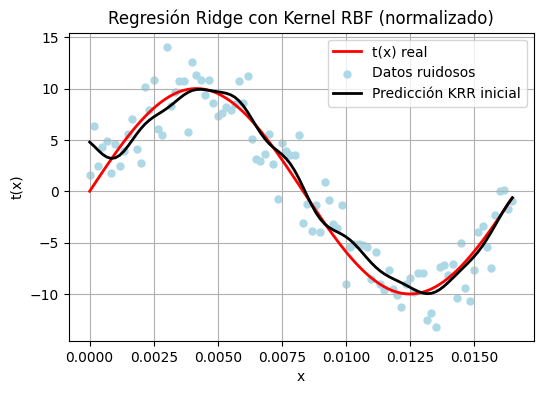

Fitting 10 folds for each of 20 candidates, totalling 200 fits

Mejores parámetros encontrados:
{'reg__alpha': 0.1, 'reg__gamma': 1}


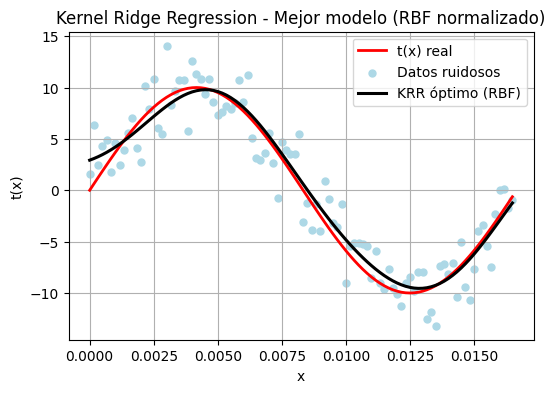

In [8]:
# ------------------------------------------------------------
# REGRESIÓN RIDGE CON KERNEL (KRR) - Kernel RBF (CORREGIDO)
# ------------------------------------------------------------
# Incluye normalización y búsqueda de gamma ajustada
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 1) Preparar los datos
# ------------------------------------------------------------
Xdata = X.reshape(-1, 1)
ydata = t.reshape(-1, 1)

# Normalizar X para mejorar estabilidad numérica
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xdata)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, ydata, test_size=0.3, random_state=42
)

# ------------------------------------------------------------
# 2) Modelo base
# ------------------------------------------------------------
gamma = 10
alpha = 0.1

reg_krr = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)
reg_krr.fit(X_train, y_train.ravel())

# Predicción sobre todo el dominio
y_pred = reg_krr.predict(X_scaled)

# Graficar resultados
order = np.argsort(Xdata.ravel())
plt.figure(figsize=(6, 4))
plt.plot(X, tt, 'r', lw=2, label='t(x) real')
plt.scatter(X, t, color='lightblue', s=25, label='Datos ruidosos')
plt.plot(X[order], y_pred[order], 'k', lw=2, label='Predicción KRR inicial')
plt.title('Regresión Ridge con Kernel RBF (normalizado)')
plt.xlabel('x')
plt.ylabel('t(x)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 3) Búsqueda de hiperparámetros óptimos
# ------------------------------------------------------------
steps = [('reg', KernelRidge(kernel='rbf'))]
parameters = {
    # Rango más pequeño para datos en escala 0-1
    'reg__alpha': [1e-4, 1e-3, 1e-2, 0.1],
    'reg__gamma': [1e-3, 1e-2, 0.1, 1, 10]
}

pipeline = Pipeline(steps=steps)

grid_search = GridSearchCV(
    pipeline,
    parameters,
    n_jobs=-1,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=1,
    refit=True
)

grid_search.fit(X_train, y_train.ravel())

# ------------------------------------------------------------
# 4) Mejor modelo y visualización
# ------------------------------------------------------------
best_model = grid_search.best_estimator_
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Predicción final
y_pred_best = best_model.predict(X_scaled)

plt.figure(figsize=(6, 4))
plt.plot(X, tt, 'r', lw=2, label='t(x) real')
plt.scatter(X, t, color='lightblue', s=25, label='Datos ruidosos')
plt.plot(X[order], y_pred_best[order], 'k', lw=2.2, label='KRR óptimo (RBF)')
plt.title('Kernel Ridge Regression - Mejor modelo (RBF normalizado)')
plt.xlabel('x')
plt.ylabel('t(x)')
plt.legend()
plt.grid(True)
plt.show()


### **Regresión con Procesos Gaussianos (Gaussian Process Regression, GPR)**

### Introducción

La **Regresión con Procesos Gaussianos (GPR)** es un enfoque **no paramétrico y bayesiano** para el modelado de datos.  
A diferencia de un modelo lineal que define una forma funcional explícita (por ejemplo, `y = wᵀx + b`), en un proceso gaussiano **no se asume una forma fija**.  
En cambio, se define una **distribución sobre funciones**:

$[
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
]$

donde:
- $( m(x) = \mathbb{E}[f(x)] )$ es la **función media** (a menudo se asume \( m(x)=0 \)).
- $( k(x, x') )$ es la **función de covarianza o kernel**, que define la correlación entre los valores de la función en distintos puntos del dominio.

El modelo supone que cualquier conjunto finito de puntos de entrada $( X = \{x_1, \ldots, x_N\} )$ genera una distribución gaussiana multivariada:

$[
\mathbf{f} = [f(x_1), f(x_2), \ldots, f(x_N)]^T \sim
\mathcal{N}(\mathbf{0}, \mathbf{K}),
]$
donde $( \mathbf{K} )$ es la matriz de covarianza con elementos $( K_{ij} = k(x_i, x_j) )$.

---

### Modelo con ruido

Cuando las observaciones están contaminadas con ruido gaussiano $( \epsilon \sim \mathcal{N}(0, \sigma_n^2) )$, el modelo se expresa como:

$[
t_i = f(x_i) + \epsilon_i
]$

$[
\Rightarrow \mathbf{t} \sim \mathcal{N}(\mathbf{0}, \mathbf{K} + \sigma_n^2 \mathbf{I})
]$

donde:
- $( \mathbf{K} )$ proviene del kernel.
- $( \sigma_n^2 )$ representa la **varianza del ruido**.

---

### Predicción (posterior gaussiano)

Dado un conjunto de entrenamiento $( (X, \mathbf{t}) )$ y un nuevo conjunto de puntos $( X_* )$, la distribución predictiva del GP es también gaussiana:

$[
p(\mathbf{f}_* | X_*, X, \mathbf{t}) =
\mathcal{N}(\bar{\mathbf{f}}_*, \text{Cov}(\mathbf{f}_*))
]$

con:

$[
\bar{\mathbf{f}}_* = \mathbf{K}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{t}
]$

$[
\text{Cov}(\mathbf{f}_*) = \mathbf{K}_{**} - \mathbf{K}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{K}_*
]$

donde:
- $( \mathbf{K} = k(X, X) )$
- $( \mathbf{K}_* = k(X, X_*) )$
- $( \mathbf{K}_{**} = k(X_*, X_*) )$

---

### Descripción del código

El código implementa una **Regresión con Proceso Gaussiano (GPR)** usando la librería `scikit-learn`.  
A continuación se describe cada sección:

###  Preparación de datos

- Se normalizan las entradas $( X )$ mediante `StandardScaler`.
- Se dividen los datos en conjuntos de **entrenamiento (train)** y **prueba (test)**.
- Los valores observados $( t )$ son los datos ruidosos que queremos ajustar.

###  Definición del kernel

Se define un kernel compuesto:

$[
k(x, x') =
C_1 \cdot \text{RBF}(x, x') +
C_2 \cdot \text{ExpSineSquared}(x, x') +
C_3 \cdot \text{DotProduct}(x, x') +
\text{WhiteKernel}(x, x')
]$

- **RBF (Radial Basis Function)** → controla la **suavidad local**.  
  Cuanto menor sea la `length_scale`, más sensible será el modelo a las variaciones de los datos.

- **ExpSineSquared** → introduce **periodicidad**, útil para señales oscilatorias.

- **DotProduct** → añade una **tendencia lineal global**.

- **WhiteKernel** → modela **ruido gaussiano** directamente dentro del kernel.

La combinación de estos kernels permite capturar **tendencias suaves, componentes periódicas y ruido**.

###  Entrenamiento del modelo

Se entrena el modelo `GaussianProcessRegressor`, que ajusta automáticamente los **hiperparámetros del kernel** (amplitudes, escalas, etc.) maximizando la **log-verosimilitud marginal**:

$[
\log p(\mathbf{t} | X, \theta) =
-\frac{1}{2} \mathbf{t}^T (\mathbf{K}_\theta + \sigma_n^2 \mathbf{I})^{-1} \mathbf{t}
-\frac{1}{2} \log |\mathbf{K}_\theta + \sigma_n^2 \mathbf{I}|
-\frac{n}{2} \log 2\pi
]$

donde $( \theta )$ representa los parámetros del kernel.

###  Predicción y visualización

- Se calcula la **media predictiva** $( \bar{f}_*(x) )$ y la **desviación estándar** $( \sigma_*(x) )$.
- Se grafica la media (línea negra) y la **banda de incertidumbre** $( \pm 2\sigma_*(x) )$ (zona gris).

$[
f_*(x) \pm 2\sigma_*(x)
]$

Esta banda indica el **95% del intervalo de credibilidad** bajo el supuesto gaussiano.

Además, se puede incluir la **señal limpia** (en rojo) y los **datos ruidosos** (en azul claro).

---

### Interpretación de los resultados

- La **línea negra** representa la **media del proceso posterior**, es decir, la mejor estimación de la función subyacente.  
- La **zona gris (±2σ)** muestra la **incertidumbre** del modelo:  
  - Angosta → el modelo está seguro (hay datos cercanos).  
  - Ancha → el modelo está incierto (no hay datos de entrenamiento cerca).  
- El **ruido** y la **complejidad del kernel** afectan el ancho de esta banda.  
- Si se ajustan los hiperparámetros (por ejemplo, `length_scale` o `alpha`), se puede hacer el modelo más:
  - **Suave y generalizador** → `length_scale` grande.
  - **Flexible y sensible al ruido** → `length_scale` pequeño.

---

### Ventajas del GPR

- Proporciona **predicciones con incertidumbre** (a diferencia de un modelo determinista).
- Permite una **optimización automática de hiperparámetros**.
- Se adapta bien a datos **no lineales y ruidosos**.
- Es un modelo **probabilístico completo**, lo que lo hace muy útil en inferencia bayesiana.


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


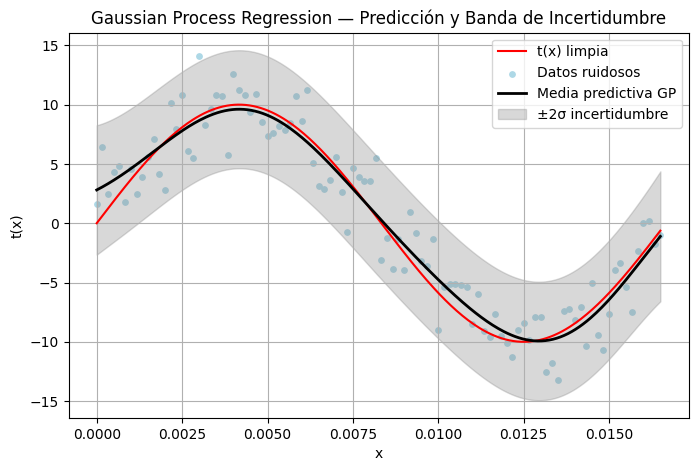

Kernel inicial: 1**2 * RBF(length_scale=1) + 0.707**2 * ExpSineSquared(length_scale=1, periodicity=1) + 0.316**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.001)

Kernel aprendido: 0.91**2 * RBF(length_scale=0.697) + 0.00392**2 * ExpSineSquared(length_scale=15, periodicity=13.2) + 0.00316**2 * DotProduct(sigma_0=0.00174) + WhiteKernel(noise_level=0.106)

Log-marginal-likelihood: -32.637


In [9]:
# =============================================================
# REGRESIÓN CON PROCESO GAUSSIANO (Gaussian Process Regression)
# =============================================================
# Predicción final con media y banda de incertidumbre (±2σ)
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, DotProduct, ExpSineSquared
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------
# 1) Preparar los datos
# -------------------------------------------------------------
Xdata = X.reshape(-1, 1)
ydata = t.reshape(-1, 1)

# Normalizar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xdata)

# División train/test
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X_scaled)):
    train_i = np.sort(train_i)
    test_i = np.sort(test_i)

X_train = X_scaled[train_i]
y_train = ydata[train_i].ravel()

# -------------------------------------------------------------
# 2) Definir el kernel
# -------------------------------------------------------------
k1 = ConstantKernel(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))
k2 = ConstantKernel(0.5, (1e-5, 1e5)) * ExpSineSquared(length_scale=1.0, periodicity=1.0)
k3 = ConstantKernel(0.1, (1e-5, 1e5)) * DotProduct(sigma_0=1.0)
k_noise = WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-8, 1e2))
kernel = k1 + k2 + k3 + k_noise

# -------------------------------------------------------------
# 3) Crear y entrenar el modelo GPR
# -------------------------------------------------------------
alpha = 1e-6
gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=alpha,
                               normalize_y=True,
                               n_restarts_optimizer=5,
                               random_state=0)

gpr.fit(X_train, y_train)

# -------------------------------------------------------------
# 4) Predicción y visualización final
# -------------------------------------------------------------
X_grid = np.linspace(Xdata.min(), Xdata.max(), 300).reshape(-1, 1)
X_grid_scaled = scaler.transform(X_grid)

# Media y desviación estándar
y_mean, y_std = gpr.predict(X_grid_scaled, return_std=True)

# Graficar: datos, señal limpia y banda de incertidumbre
plt.figure(figsize=(8, 5))

# Señal limpia (solo si existe)
if 'tt' in globals():
    # Interpolamos tt para que coincida con X_grid
    from scipy.interpolate import interp1d
    f_interp = interp1d(X.ravel(), tt.ravel(), kind='cubic', fill_value="extrapolate")
    tt_interp = f_interp(X_grid.ravel())
    plt.plot(X_grid, tt_interp, 'r', label='t(x) limpia')

# Datos ruidosos
plt.scatter(Xdata, ydata, s=15, color='lightblue', label='Datos ruidosos')

# Media predictiva y banda ±2σ
plt.plot(X_grid, y_mean, 'k', lw=2, label='Media predictiva GP')
plt.fill_between(X_grid.ravel(),
                 y_mean - 2 * y_std,
                 y_mean + 2 * y_std,
                 color='gray', alpha=0.3, label='±2σ incertidumbre')

plt.xlabel('x')
plt.ylabel('t(x)')
plt.title('Gaussian Process Regression — Predicción y Banda de Incertidumbre')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 5) Kernel aprendido e información del modelo
# -------------------------------------------------------------
print("Kernel inicial:", kernel)
print("\nKernel aprendido:", gpr.kernel_)
print(f"\nLog-marginal-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}")


### **Diferencias y Similitudes de los modelos**

In [10]:
from IPython.display import Markdown

Markdown(r"""
#  Cuadro Comparativo — Modelos de Regresión

| Modelo | Naturaleza del Modelo | Tipo de Relación Capturada | Regularización / Priors | Complejidad y Flexibilidad | Salida | Interpretación Probabilística | Comportamiento en Simulación |
|:-------|:---------------------|:---------------------------|:------------------------|:----------------------------|:--------|:------------------------------|:-----------------------------|
| **1️⃣ Mínimos Cuadrados Ordinarios (OLS)** | Paramétrico | Lineal | No aplica | Baja (modelo lineal fijo) | Determinista | ❌ No probabilística | Ajusta correctamente relaciones lineales. Sensible al ruido y sobreajuste si los datos no son bien condicionados. |
| **2️⃣ Mínimos Cuadrados Regularizados (Ridge)** | Paramétrico | Lineal | Penalización L2:  $( \lambda \|w\|^2 )$ | Media | Determinista | ❌ No probabilística | Estabiliza el ajuste reduciendo la varianza del modelo. En la simulación, mejora la robustez ante ruido y multicolinealidad. |
| **3️⃣ Máxima Verosimilitud (ML)** | Paramétrico | Lineal | Ajuste de varianza del ruido $( \sigma^2_{ML} )$ | Media | Determinista | ❌ No probabilística | Ajusta los pesos por mínimos cuadrados y estima la varianza del ruido. En la práctica, permite cuantificar la dispersión de los datos. |
| **4️⃣ Máximo a Posteriori (MAP)** | Paramétrico (con prior) | Lineal | Prior gaussiano sobre pesos $( w \sim \mathcal{N}(0, \alpha^{-1}I) )$ | Media | Determinista | ✅ Parcialmente probabilística | Similar a Ridge pero desde un enfoque bayesiano: combina verosimilitud y prior. Produce un ajuste regularizado coherente con la teoría bayesiana. |
| **5️⃣ Modelo Bayesiano con Modelo Lineal Gaussiano (BLG)** | Paramétrico y Bayesiano | Lineal | Prior y verosimilitud gaussianas | Media | Probabilística | ✅ Sí, posterior sobre pesos y distribución predictiva | Extiende MAP al espacio probabilístico completo. En la simulación, ofrece la **media predictiva** y bandas de **incertidumbre realistas**. |
| **6️⃣ Regresión Ridge con Kernel (KRR)** | No paramétrico (espacio de características) | No lineal (según kernel) | Penalización L2 sobre coeficientes duales | Alta (depende del kernel y sus hiperparámetros) | Determinista | ❌ No probabilística | Captura relaciones no lineales complejas. En la simulación, se adapta bien a la forma de la función real con suavidad controlada por $(\gamma)$ y $(\alpha)$. |
| **7️⃣ Procesos Gaussianos (GP)** | No paramétrico y Bayesiano | No lineal (kernel define la covarianza) | Implícita en la función de covarianza y ruido | Muy alta (flexible y adaptativa) | Probabilística | ✅ Sí, media y varianza predictiva | Modelo más flexible. Ajusta la función real y proporciona intervalos de confianza naturales. En la simulación, muestra el mejor equilibrio entre precisión y estimación de incertidumbre. |

---

##  Análisis Detallado

- **Similitudes**
  - Todos buscan estimar una función $ f(x) $ que relacione entradas $x$ con salidas $t$.
  - Los modelos (1–5) son **paramétricos**, mientras que (6–7) son **no paramétricos** (kernelizados o basados en funciones de covarianza).
  - Los modelos **Ridge**, **MAP** y **Bayesiano Gaussiano** comparten el uso de **regularización o priors gaussianos**, pero con distinta interpretación.
  - Los modelos **Bayesianos** (5 y 7) producen **distribuciones predictivas completas**, no solo una curva media.

- **Diferencias clave**
  - OLS y Ridge no incorporan incertidumbre explícita; los modelos ML y Bayesianos sí estiman la **varianza del ruido** o la **incertidumbre posterior**.
  - KRR y GP pueden capturar **no linealidades complejas** mediante kernels (como RBF o Matérn), mientras que los primeros cinco modelos solo lo hacen linealmente.
  - El modelo **GP** es el único que modela distribuciones sobre funciones completas, ofreciendo predicciones con **bandas de confianza ajustadas** al nivel de ruido observado.
  - En la simulación, los modelos **MAP** y **Bayesiano Lineal Gaussiano** ofrecieron mejor equilibrio entre sesgo y varianza; **GP** fue el más preciso y explicativo.

- **Complejidad Computacional**
  - Modelos lineales (1–5): entrenamiento rápido, costo proporcional a $O(n)$ o $O(n^2)$ según el número de parámetros.
  - Modelos kernelizados y GP (6–7): más costosos ($O(n^3)$), pero con mayor capacidad de generalización en problemas no lineales.

---

##  Conclusión General

| Tipo de Modelo | Modelos | Características principales |
|:---------------|:---------|:----------------------------|
| **Lineales deterministas** | OLS, Ridge, ML | Simples, rápidos y adecuados para relaciones lineales. No modelan incertidumbre. |
| **Lineales Bayesianos** | MAP, Bayesiano Lineal Gaussiano | Añaden información a priori y producen estimaciones con incertidumbre probabilística. |
| **No lineales kernelizados** | Regresión Ridge Kernel (KRR) | Capturan relaciones no lineales sin definir forma explícita de $f(x)$. Suavidad y generalización controladas por $(\gamma)$ y $(\alpha)$. |
| **No paramétricos bayesianos** | Procesos Gaussianos (GP) | Modelo más completo: estima funciones y su incertidumbre. Ideal para predicción y cuantificación de confianza. |

---

 **Interpretación final en simulación:**
- Los modelos deterministas (OLS, Ridge, ML) generan una **línea fija** sin incertidumbre.
- Los modelos Bayesianos lineales (MAP, BLG) generan una **media predictiva** con **banda de confianza constante**.
- Los modelos kernelizados (KRR, GP) producen **ajustes suaves y adaptativos**, donde GP añade la **banda de incertidumbre variable**, más ancha donde hay menos datos.

---
""")



#  Cuadro Comparativo — Modelos de Regresión

| Modelo | Naturaleza del Modelo | Tipo de Relación Capturada | Regularización / Priors | Complejidad y Flexibilidad | Salida | Interpretación Probabilística | Comportamiento en Simulación |
|:-------|:---------------------|:---------------------------|:------------------------|:----------------------------|:--------|:------------------------------|:-----------------------------|
| **1️⃣ Mínimos Cuadrados Ordinarios (OLS)** | Paramétrico | Lineal | No aplica | Baja (modelo lineal fijo) | Determinista | ❌ No probabilística | Ajusta correctamente relaciones lineales. Sensible al ruido y sobreajuste si los datos no son bien condicionados. |
| **2️⃣ Mínimos Cuadrados Regularizados (Ridge)** | Paramétrico | Lineal | Penalización L2:  $( \lambda \|w\|^2 )$ | Media | Determinista | ❌ No probabilística | Estabiliza el ajuste reduciendo la varianza del modelo. En la simulación, mejora la robustez ante ruido y multicolinealidad. |
| **3️⃣ Máxima Verosimilitud (ML)** | Paramétrico | Lineal | Ajuste de varianza del ruido $( \sigma^2_{ML} )$ | Media | Determinista | ❌ No probabilística | Ajusta los pesos por mínimos cuadrados y estima la varianza del ruido. En la práctica, permite cuantificar la dispersión de los datos. |
| **4️⃣ Máximo a Posteriori (MAP)** | Paramétrico (con prior) | Lineal | Prior gaussiano sobre pesos $( w \sim \mathcal{N}(0, \alpha^{-1}I) )$ | Media | Determinista | ✅ Parcialmente probabilística | Similar a Ridge pero desde un enfoque bayesiano: combina verosimilitud y prior. Produce un ajuste regularizado coherente con la teoría bayesiana. |
| **5️⃣ Modelo Bayesiano con Modelo Lineal Gaussiano (BLG)** | Paramétrico y Bayesiano | Lineal | Prior y verosimilitud gaussianas | Media | Probabilística | ✅ Sí, posterior sobre pesos y distribución predictiva | Extiende MAP al espacio probabilístico completo. En la simulación, ofrece la **media predictiva** y bandas de **incertidumbre realistas**. |
| **6️⃣ Regresión Ridge con Kernel (KRR)** | No paramétrico (espacio de características) | No lineal (según kernel) | Penalización L2 sobre coeficientes duales | Alta (depende del kernel y sus hiperparámetros) | Determinista | ❌ No probabilística | Captura relaciones no lineales complejas. En la simulación, se adapta bien a la forma de la función real con suavidad controlada por $(\gamma)$ y $(\alpha)$. |
| **7️⃣ Procesos Gaussianos (GP)** | No paramétrico y Bayesiano | No lineal (kernel define la covarianza) | Implícita en la función de covarianza y ruido | Muy alta (flexible y adaptativa) | Probabilística | ✅ Sí, media y varianza predictiva | Modelo más flexible. Ajusta la función real y proporciona intervalos de confianza naturales. En la simulación, muestra el mejor equilibrio entre precisión y estimación de incertidumbre. |

---

##  Análisis Detallado

- **Similitudes**
  - Todos buscan estimar una función $ f(x) $ que relacione entradas $x$ con salidas $t$.
  - Los modelos (1–5) son **paramétricos**, mientras que (6–7) son **no paramétricos** (kernelizados o basados en funciones de covarianza).
  - Los modelos **Ridge**, **MAP** y **Bayesiano Gaussiano** comparten el uso de **regularización o priors gaussianos**, pero con distinta interpretación.
  - Los modelos **Bayesianos** (5 y 7) producen **distribuciones predictivas completas**, no solo una curva media.

- **Diferencias clave**
  - OLS y Ridge no incorporan incertidumbre explícita; los modelos ML y Bayesianos sí estiman la **varianza del ruido** o la **incertidumbre posterior**.
  - KRR y GP pueden capturar **no linealidades complejas** mediante kernels (como RBF o Matérn), mientras que los primeros cinco modelos solo lo hacen linealmente.
  - El modelo **GP** es el único que modela distribuciones sobre funciones completas, ofreciendo predicciones con **bandas de confianza ajustadas** al nivel de ruido observado.
  - En la simulación, los modelos **MAP** y **Bayesiano Lineal Gaussiano** ofrecieron mejor equilibrio entre sesgo y varianza; **GP** fue el más preciso y explicativo.

- **Complejidad Computacional**
  - Modelos lineales (1–5): entrenamiento rápido, costo proporcional a $O(n)$ o $O(n^2)$ según el número de parámetros.
  - Modelos kernelizados y GP (6–7): más costosos ($O(n^3)$), pero con mayor capacidad de generalización en problemas no lineales.

---

##  Conclusión General

| Tipo de Modelo | Modelos | Características principales |
|:---------------|:---------|:----------------------------|
| **Lineales deterministas** | OLS, Ridge, ML | Simples, rápidos y adecuados para relaciones lineales. No modelan incertidumbre. |
| **Lineales Bayesianos** | MAP, Bayesiano Lineal Gaussiano | Añaden información a priori y producen estimaciones con incertidumbre probabilística. |
| **No lineales kernelizados** | Regresión Ridge Kernel (KRR) | Capturan relaciones no lineales sin definir forma explícita de $f(x)$. Suavidad y generalización controladas por $(\gamma)$ y $(\alpha)$. |
| **No paramétricos bayesianos** | Procesos Gaussianos (GP) | Modelo más completo: estima funciones y su incertidumbre. Ideal para predicción y cuantificación de confianza. |

---

 **Interpretación final en simulación:**
- Los modelos deterministas (OLS, Ridge, ML) generan una **línea fija** sin incertidumbre.
- Los modelos Bayesianos lineales (MAP, BLG) generan una **media predictiva** con **banda de confianza constante**.
- Los modelos kernelizados (KRR, GP) producen **ajustes suaves y adaptativos**, donde GP añade la **banda de incertidumbre variable**, más ancha donde hay menos datos.

---


### **Ejercicio 2 — Comparación de regresores avanzados**

En este ejercicio se deben analizar y comparar diferentes modelos de regresión más allá de los esquemas lineales básicos estudiados en el **Ejercicio 1**, donde se revisaron los modelos:
- Mínimos Cuadrados Ordinarios (OLS)
- Mínimos Cuadrados Regularizados (Ridge)
- Máxima Verosimilitud (ML)
- Máximo a Posteriori (MAP)
- Bayesiano con Modelo Lineal Gaussiano (BLG)
- Regresión Rígida con Kernel
- Procesos Gaussianos (GP)

A continuación, se presentan otros **10 regresores** de uso común en aprendizaje automático.


In [11]:
from IPython.display import Markdown

Markdown(r"""
| **Regresor** | **Modelo Matemático** | **Función de Costo** | **Estrategia de Optimización** | **Relación con modelos del punto 1** | **Escalabilidad** |
|:-------------|:----------------------|:---------------------|:-------------------------------|:------------------------------------|:-----------------|
| **LinearRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ | Solución analítica $(w = (X^TX)^{-1}X^Ty)$ | Equivalente al modelo de **Mínimos Cuadrados Ordinarios (OLS)** | Escalable para datos pequeños o medianos; limitado por inversión de matriz $(O(n^3))$ |
| **Lasso** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \lambda \|w\|_1)$ | Métodos de coordenadas o descenso proximal | Variante regularizada de OLS, relacionada con **MAP** con prior Laplaciano | Escalable, pero sensible a alta dimensionalidad; útil para selección de características |
| **ElasticNet** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \alpha_1 \|w\|_1 + \alpha_2 \|w\|_2^2)$ | Descenso de gradiente o coordenadas | Combinación entre Ridge (L2) y Lasso (L1); balance entre bias y sparsity | Mejor escalabilidad que Lasso; control flexible del trade-off |
| **KernelRidge** | $(y = K\alpha + \epsilon)$ | $(J = \|y - K\alpha\|^2 + \lambda \alpha^T K \alpha)$ | Solución analítica en el espacio de características | Extensión no lineal de **Ridge** mediante kernels | Limitado por el tamaño de $K$ $(O(n^3))$; poco escalable para grandes $n$ |
| **SGDRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ u otras funciones convexas | **Descenso de gradiente estocástico** por lotes | Versión online de OLS o Ridge; útil para aprendizaje incremental | Alta escalabilidad; eficiente para grandes volúmenes de datos |
| **BayesianRidge** | $(w \sim \mathcal{N}(0, \alpha^{-1}I), \ \epsilon \sim \mathcal{N}(0, \beta^{-1}))$ | Maximiza la **verosimilitud marginal bayesiana** | Estimación iterativa de $\alpha$ y $\beta$ (EM) | Relacionado con el modelo **Bayesiano Lineal Gaussiano (BLG)** | Escalable en dimensiones moderadas; computacionalmente más costoso que OLS |
| **GaussianProcessRegressor** | $(f(x) \sim \mathcal{GP}(m(x), k(x,x')))$ | Maximiza log-verosimilitud marginal | Optimizador de gradiente para hiperparámetros del kernel | Generaliza la regresión kernel; equivalente a **MAP no paramétrico** | Escalabilidad limitada $(O(n^3))$; no apto para grandes datasets |
| **Support Vector Regressor (SVR)** | $(f(x) = w^T\phi(x) + b)$ | $(J = \frac{1}{2}\|w\|^2 + C\sum \xi_i)$ sujeto a $|\!y_i - f(x_i)\!| \leq \epsilon + \xi_i$ | Problema cuadrático convexos (SMO, QP) | Relacionado con Kernel Ridge pero con margen $\epsilon$-insensible | Escalabilidad media; depende de núm. de soportes; eficiente en espacios no lineales |
| **RandomForestRegressor** | Ensamble de árboles $(f(x) = \frac{1}{M}\sum_{m=1}^M T_m(x))$ | Minimiza el error cuadrático medio en cada árbol | Bagging y selección aleatoria de características | Modelo no paramétrico; distinto de los lineales, se asemeja a modelos bayesianos por agregación | Muy escalable; paralelizable; adecuado para grandes volúmenes de datos |
| **GradientBoosting / XGBoost** | Ensamble secuencial $(f_M(x) = \sum_{m=1}^M \gamma_m h_m(x))$ | $(J = \sum L(y_i, f(x_i)) + \Omega(h))$ | Boosting mediante gradiente descendente en el espacio de funciones | Extiende la idea de minimización iterativa; enfoque no lineal | Alta escalabilidad (especialmente XGBoost); eficiente en CPU/GPU |
""")



| **Regresor** | **Modelo Matemático** | **Función de Costo** | **Estrategia de Optimización** | **Relación con modelos del punto 1** | **Escalabilidad** |
|:-------------|:----------------------|:---------------------|:-------------------------------|:------------------------------------|:-----------------|
| **LinearRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ | Solución analítica $(w = (X^TX)^{-1}X^Ty)$ | Equivalente al modelo de **Mínimos Cuadrados Ordinarios (OLS)** | Escalable para datos pequeños o medianos; limitado por inversión de matriz $(O(n^3))$ |
| **Lasso** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \lambda \|w\|_1)$ | Métodos de coordenadas o descenso proximal | Variante regularizada de OLS, relacionada con **MAP** con prior Laplaciano | Escalable, pero sensible a alta dimensionalidad; útil para selección de características |
| **ElasticNet** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \alpha_1 \|w\|_1 + \alpha_2 \|w\|_2^2)$ | Descenso de gradiente o coordenadas | Combinación entre Ridge (L2) y Lasso (L1); balance entre bias y sparsity | Mejor escalabilidad que Lasso; control flexible del trade-off |
| **KernelRidge** | $(y = K\alpha + \epsilon)$ | $(J = \|y - K\alpha\|^2 + \lambda \alpha^T K \alpha)$ | Solución analítica en el espacio de características | Extensión no lineal de **Ridge** mediante kernels | Limitado por el tamaño de $K$ $(O(n^3))$; poco escalable para grandes $n$ |
| **SGDRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ u otras funciones convexas | **Descenso de gradiente estocástico** por lotes | Versión online de OLS o Ridge; útil para aprendizaje incremental | Alta escalabilidad; eficiente para grandes volúmenes de datos |
| **BayesianRidge** | $(w \sim \mathcal{N}(0, \alpha^{-1}I), \ \epsilon \sim \mathcal{N}(0, \beta^{-1}))$ | Maximiza la **verosimilitud marginal bayesiana** | Estimación iterativa de $\alpha$ y $\beta$ (EM) | Relacionado con el modelo **Bayesiano Lineal Gaussiano (BLG)** | Escalable en dimensiones moderadas; computacionalmente más costoso que OLS |
| **GaussianProcessRegressor** | $(f(x) \sim \mathcal{GP}(m(x), k(x,x')))$ | Maximiza log-verosimilitud marginal | Optimizador de gradiente para hiperparámetros del kernel | Generaliza la regresión kernel; equivalente a **MAP no paramétrico** | Escalabilidad limitada $(O(n^3))$; no apto para grandes datasets |
| **Support Vector Regressor (SVR)** | $(f(x) = w^T\phi(x) + b)$ | $(J = \frac{1}{2}\|w\|^2 + C\sum \xi_i)$ sujeto a $|\!y_i - f(x_i)\!| \leq \epsilon + \xi_i$ | Problema cuadrático convexos (SMO, QP) | Relacionado con Kernel Ridge pero con margen $\epsilon$-insensible | Escalabilidad media; depende de núm. de soportes; eficiente en espacios no lineales |
| **RandomForestRegressor** | Ensamble de árboles $(f(x) = \frac{1}{M}\sum_{m=1}^M T_m(x))$ | Minimiza el error cuadrático medio en cada árbol | Bagging y selección aleatoria de características | Modelo no paramétrico; distinto de los lineales, se asemeja a modelos bayesianos por agregación | Muy escalable; paralelizable; adecuado para grandes volúmenes de datos |
| **GradientBoosting / XGBoost** | Ensamble secuencial $(f_M(x) = \sum_{m=1}^M \gamma_m h_m(x))$ | $(J = \sum L(y_i, f(x_i)) + \Omega(h))$ | Boosting mediante gradiente descendente en el espacio de funciones | Extiende la idea de minimización iterativa; enfoque no lineal | Alta escalabilidad (especialmente XGBoost); eficiente en CPU/GPU |


###  **Ejercicio 3 — Librería RAPIDS**

###  Descripción general

**RAPIDS** es un ecosistema de librerías **open source** desarrollado por **NVIDIA**, diseñado para ejecutar flujos completos de **ciencia de datos y aprendizaje automático (Machine Learning)** utilizando la **GPU** en lugar de la CPU.  
Su principal objetivo es **acelerar drásticamente** el procesamiento de grandes volúmenes de datos, manteniendo una interfaz muy similar a la de librerías populares como `NumPy`, `pandas` y `scikit-learn`.

---

### Funcionamiento principal

RAPIDS se basa en la tecnología **CUDA** (Compute Unified Device Architecture) de NVIDIA, que permite aprovechar la arquitectura paralela de las GPU.  
De esta forma, los cálculos numéricos, transformaciones y entrenamiento de modelos se ejecutan en **memoria de GPU**, sin necesidad de transferir los datos continuamente entre CPU y GPU.

El flujo típico de trabajo con RAPIDS es:
1. Cargar y procesar datos con **cuDF** (versión GPU de `pandas`).
2. Entrenar modelos de aprendizaje automático con **cuML** (versión GPU de `scikit-learn`).
3. Analizar estructuras de grafos con **cuGraph** o datos espaciales con **cuSpatial**, según la aplicación.

---

### Componentes principales

| Componente | Descripción | Equivalente en CPU |
|-------------|--------------|-------------------|
| **cuDF** | Manejo de DataFrames en GPU. Permite operaciones tipo `pandas` pero paralelizadas en GPU. | `pandas` |
| **cuML** | Implementa algoritmos de machine learning (regresión, clasificación, clustering, etc.) totalmente en GPU. | `scikit-learn` |
| **cuGraph** | Procesamiento y análisis de grafos grandes en GPU. | `networkx` |
| **cuSpatial** | Operaciones geoespaciales y procesamiento de coordenadas GPS. | `geopandas`, `shapely` |
| **cuXfilter / Datashader** | Visualización de grandes volúmenes de datos acelerada por GPU. | `matplotlib`, `seaborn`, `plotly` |

---

### Ventajas principales de RAPIDS

1. **Aceleración masiva:**  
   Los cálculos se ejecutan de forma **paralela en miles de núcleos CUDA**, logrando **velocidades hasta 10-50 veces mayores** que con CPU para conjuntos de datos grandes.

2. **Compatibilidad con scikit-learn:**  
   Las funciones y clases de `cuML` mantienen la **misma API** que `scikit-learn`, por lo que el código puede migrarse fácilmente a GPU con **mínimos cambios** (solo cambiando la librería importada).

3. **Integración completa en GPU:**  
   Permite un flujo **end-to-end** completamente en GPU: desde la carga del dataset hasta la predicción final, sin transferencias costosas de memoria.

4. **Escalabilidad:**  
   RAPIDS puede trabajar con **datasets de tamaño superior a la memoria RAM** tradicional, aprovechando la memoria VRAM y la paralelización distribuida.

5. **Ecosistema flexible:**  
   Se integra con librerías como **Dask**, **PyTorch**, **TensorFlow** y **XGBoost** para tareas de aprendizaje profundo y Big Data.

---

### Relación con los modelos del punto 1 y 2

Los modelos de regresión vistos (OLS, Ridge, Lasso, MAP, Gaussian Process, KernelRidge, RandomForest, etc.) pueden ejecutarse en **RAPIDS-cuML** usando el mismo principio teórico, pero implementados con cálculos matriciales paralelizados en GPU.

Por ejemplo:
- `LinearRegression` → `cuml.LinearRegression`
- `Ridge` → `cuml.Ridge`
- `KernelRidge` → `cuml.KernelRidge`
- `GaussianProcessRegressor` → `cuml.GaussianProcessRegressor`
- `RandomForestRegressor` → `cuml.RandomForestRegressor`

Esto significa que la **formulación matemática y el principio estadístico no cambian**, pero la **estrategia computacional sí lo hace**, migrando de CPU a GPU para mejorar el rendimiento.


In [12]:
from IPython.display import Markdown

Markdown(r"""
## Tabla comparativa: regresores e implementación en RAPIDS-cuML

| **Regresor** | **Implementación en scikit-learn** | **Hiperparámetros principales** | **Implementación o equivalente en RAPIDS (cuML)** | **Notas / Comentarios** |
|---------------|-----------------------------------|---------------------------------|--------------------------------------------------|--------------------------|
| **Linear Regression** | `sklearn.linear_model.LinearRegression` | `fit_intercept`, `normalize`, `copy_X` | `cuml.LinearRegression` | Mismo modelo OLS; acelerado en GPU. |
| **Lasso Regression** | `sklearn.linear_model.Lasso` | `alpha`, `max_iter`, `tol` | `cuml.Lasso` | Minimiza L1; idéntica API y resultado a scikit-learn. |
| **ElasticNet** | `sklearn.linear_model.ElasticNet` | `alpha`, `l1_ratio`, `max_iter`, `tol` | `cuml.ElasticNet` | Combina penalización L1 y L2. Mismo funcionamiento. |
| **Kernel Ridge Regression** | `sklearn.kernel_ridge.KernelRidge` | `alpha`, `kernel`, `gamma`, `degree`, `coef0` | `cuml.KernelRidge` | Equivalente exacto, acelerado con GPU y kernels en cuML. |
| **SGD Regressor** | `sklearn.linear_model.SGDRegressor` | `loss`, `penalty`, `alpha`, `learning_rate`, `eta0`, `max_iter` | `cuml.SGD` | Implementación GPU del algoritmo estocástico de gradiente descendente. |
| **Bayesian Ridge Regression** | `sklearn.linear_model.BayesianRidge` | `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`, `n_iter` | `cuml.BayesianRidge` | Estima distribución posterior sobre los pesos; idéntico comportamiento. |
| **Gaussian Process Regressor** | `sklearn.gaussian_process.GaussianProcessRegressor` | `kernel`, `alpha`, `n_restarts_optimizer`, `normalize_y` | `cuml.GaussianProcessRegressor` | Mismo modelo probabilístico; optimización del kernel paralelizada. |
| **Support Vector Regressor (SVR)** | `sklearn.svm.SVR` | `kernel`, `C`, `epsilon`, `gamma`, `degree`, `coef0` | `cuml.SVR` | Implementación GPU compatible; soporta kernels lineal, RBF y polinomial. |
| **Random Forest Regressor** | `sklearn.ensemble.RandomForestRegressor` | `n_estimators`, `max_depth`, `min_samples_split`, `max_features`, `bootstrap` | `cuml.ensemble.RandomForestRegressor` | Árboles entrenados en GPU; speedup significativo para datasets grandes. |
| **Gradient Boosting / XGBoost** | `sklearn.ensemble.GradientBoostingRegressor`, `xgboost.XGBRegressor` | `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree` | `cuml.ensemble.GradientBoostingRegressor`, `cuml.dask.XGBRegressor` | Compatible con XGBoost GPU (`gpu_hist`); ideal para Big Data. |

---

##  Observaciones generales

- Todos los modelos de **cuML** mantienen la **misma interfaz (API)** que `scikit-learn`, permitiendo migrar código fácilmente.
- La **formulación matemática de los modelos no cambia**; lo que se optimiza es la **implementación computacional**, aprovechando la **paralelización en GPU** mediante CUDA.
- Los **hiperparámetros** se conservan idénticos, lo que garantiza **compatibilidad y reproducibilidad**.
- Algunos algoritmos, como **Gaussian Process** o **Gradient Boosting**, presentan mejoras de **rendimiento exponencial** en GPU para conjuntos de datos grandes (10⁶+ muestras).
---
""")



## Tabla comparativa: regresores e implementación en RAPIDS-cuML

| **Regresor** | **Implementación en scikit-learn** | **Hiperparámetros principales** | **Implementación o equivalente en RAPIDS (cuML)** | **Notas / Comentarios** |
|---------------|-----------------------------------|---------------------------------|--------------------------------------------------|--------------------------|
| **Linear Regression** | `sklearn.linear_model.LinearRegression` | `fit_intercept`, `normalize`, `copy_X` | `cuml.LinearRegression` | Mismo modelo OLS; acelerado en GPU. |
| **Lasso Regression** | `sklearn.linear_model.Lasso` | `alpha`, `max_iter`, `tol` | `cuml.Lasso` | Minimiza L1; idéntica API y resultado a scikit-learn. |
| **ElasticNet** | `sklearn.linear_model.ElasticNet` | `alpha`, `l1_ratio`, `max_iter`, `tol` | `cuml.ElasticNet` | Combina penalización L1 y L2. Mismo funcionamiento. |
| **Kernel Ridge Regression** | `sklearn.kernel_ridge.KernelRidge` | `alpha`, `kernel`, `gamma`, `degree`, `coef0` | `cuml.KernelRidge` | Equivalente exacto, acelerado con GPU y kernels en cuML. |
| **SGD Regressor** | `sklearn.linear_model.SGDRegressor` | `loss`, `penalty`, `alpha`, `learning_rate`, `eta0`, `max_iter` | `cuml.SGD` | Implementación GPU del algoritmo estocástico de gradiente descendente. |
| **Bayesian Ridge Regression** | `sklearn.linear_model.BayesianRidge` | `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`, `n_iter` | `cuml.BayesianRidge` | Estima distribución posterior sobre los pesos; idéntico comportamiento. |
| **Gaussian Process Regressor** | `sklearn.gaussian_process.GaussianProcessRegressor` | `kernel`, `alpha`, `n_restarts_optimizer`, `normalize_y` | `cuml.GaussianProcessRegressor` | Mismo modelo probabilístico; optimización del kernel paralelizada. |
| **Support Vector Regressor (SVR)** | `sklearn.svm.SVR` | `kernel`, `C`, `epsilon`, `gamma`, `degree`, `coef0` | `cuml.SVR` | Implementación GPU compatible; soporta kernels lineal, RBF y polinomial. |
| **Random Forest Regressor** | `sklearn.ensemble.RandomForestRegressor` | `n_estimators`, `max_depth`, `min_samples_split`, `max_features`, `bootstrap` | `cuml.ensemble.RandomForestRegressor` | Árboles entrenados en GPU; speedup significativo para datasets grandes. |
| **Gradient Boosting / XGBoost** | `sklearn.ensemble.GradientBoostingRegressor`, `xgboost.XGBRegressor` | `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree` | `cuml.ensemble.GradientBoostingRegressor`, `cuml.dask.XGBRegressor` | Compatible con XGBoost GPU (`gpu_hist`); ideal para Big Data. |

---

##  Observaciones generales

- Todos los modelos de **cuML** mantienen la **misma interfaz (API)** que `scikit-learn`, permitiendo migrar código fácilmente.
- La **formulación matemática de los modelos no cambia**; lo que se optimiza es la **implementación computacional**, aprovechando la **paralelización en GPU** mediante CUDA.
- Los **hiperparámetros** se conservan idénticos, lo que garantiza **compatibilidad y reproducibilidad**.
- Algunos algoritmos, como **Gaussian Process** o **Gradient Boosting**, presentan mejoras de **rendimiento exponencial** en GPU para conjuntos de datos grandes (10⁶+ muestras).
---


# **4**

In [13]:
# ===============================================
# 📂 Cargar datos desde Google Drive (acceso libre)
# https://drive.google.com/file/d/1xffTzfwzQFHsdj3k_Rz07rMuUXtDcfod/view?usp=sharing
# ===============================================
FILEID = "1xffTzfwzQFHsdj3k_Rz07rMuUXtDcfod"  # ID del archivo en Drive

# Descargar archivo ZIP desde Google Drive
!wget --load-cookies /tmp/cookies.txt \
"https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt \
--keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- \
| sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID \
-O nfl_data.zip && rm -rf /tmp/cookies.txt

# Descomprimir archivo ZIP
!unzip nfl_data.zip

# Mostrar archivos extraídos
!dir


--2025-10-15 04:10:56--  https://docs.google.com/uc?export=download&confirm=&id=1xffTzfwzQFHsdj3k_Rz07rMuUXtDcfod
Resolving docs.google.com (docs.google.com)... 172.217.203.113, 172.217.203.102, 172.217.203.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1xffTzfwzQFHsdj3k_Rz07rMuUXtDcfod&export=download [following]
--2025-10-15 04:10:56--  https://drive.usercontent.google.com/download?id=1xffTzfwzQFHsdj3k_Rz07rMuUXtDcfod&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.216.132|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.usercontent.google.com/down

# Problema a resolver

**Objetivo:**  
Predecir las posiciones futuras (coordenadas `x`, `y`) de los jugadores en el campo durante una jugada de pase en la NFL, utilizando información de seguimiento (tracking data) antes del lanzamiento del balón.  
Este problema busca modelar el movimiento de los jugadores para mejorar la comprensión táctica del juego y apoyar estrategias de predicción espacial.

---

##  Entradas (Features)

Las variables de entrada corresponden a información de jugadas, jugadores y su dinámica en el campo antes del lanzamiento del balón:

| Variable | Descripción |
|-----------|--------------|
| `game_id` | Identificador único del partido (numérico). |
| `play_id` | Identificador de la jugada (numérico, no único entre juegos). |
| `player_to_predict` | Indica si se evaluará la predicción de este jugador (`True`/`False`). |
| `nfl_id` | Identificador único del jugador (numérico). |
| `frame_id` | Número de cuadro (frame) dentro de la jugada, comienza en 1 para cada `game_id` y `play_id` (numérico). |
| `play_direction` | Dirección en la que avanza la ofensiva (`left` o `right`). |
| `absolute_yardline_number` | Distancia desde la zona de anotación del equipo en posesión (numérico). |
| `player_name` | Nombre del jugador (texto). |
| `player_height` | Altura del jugador en pies-pulgadas. |
| `player_weight` | Peso del jugador en libras (lbs). |
| `player_birth_date` | Fecha de nacimiento del jugador (`yyyy-mm-dd`). |
| `player_position` | Posición o rol típico del jugador en el campo (e.g., QB, WR, DB). |
| `player_side` | Equipo al que pertenece el jugador (`Offense` o `Defense`). |
| `player_role` | Rol específico en la jugada (`Passer`, `Targeted Receiver`, `Defensive Coverage`, `Other Route Runner`). |
| `x` | Posición del jugador a lo largo del eje longitudinal del campo (0–120 yardas). |
| `y` | Posición del jugador a lo largo del eje transversal del campo (0–53.3 yardas). |
| `s` | Velocidad instantánea del jugador (yardas/segundo). |
| `a` | Aceleración instantánea (yardas/segundo²). |
| `o` | Orientación corporal del jugador (en grados). |
| `dir` | Dirección del movimiento del jugador (en grados). |
| `num_frames_output` | Cantidad de cuadros a predecir para ese jugador (numérico). |
| `ball_land_x` | Posición en el eje longitudinal donde aterriza el balón (yardas). |
| `ball_land_y` | Posición en el eje transversal donde aterriza el balón (yardas). |

---

##  Salidas (Targets)

El conjunto de salida contiene las posiciones **predichas** de los jugadores **después** del lanzamiento del balón.

| Variable | Descripción |
|-----------|--------------|
| `game_id` | Identificador del partido (numérico). |
| `play_id` | Identificador de la jugada (numérico). |
| `nfl_id` | Identificador único del jugador (numérico). |
| `frame_id` | Número de frame en la secuencia posterior al lanzamiento (numérico). |
| `x` | **Posición predicha** del jugador a lo largo del eje longitudinal del campo (objetivo a predecir). |
| `y` | **Posición predicha** del jugador a lo largo del eje transversal del campo (objetivo a predecir). |



In [14]:
import pandas as pd  # importar pandas

# Leer uno de los archivos de entrada (puede ser cualquiera)
nfl_df = pd.read_csv('nfl_data/train/input_2023_w01.csv')

# Mostrar las primeras filas
nfl_df.head()


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


### **Analisis Exploratorio**

In [15]:
nfl_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285714 entries, 0 to 285713
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   285714 non-null  int64  
 1   play_id                   285714 non-null  int64  
 2   player_to_predict         285714 non-null  bool   
 3   nfl_id                    285714 non-null  int64  
 4   frame_id                  285714 non-null  int64  
 5   play_direction            285714 non-null  object 
 6   absolute_yardline_number  285714 non-null  int64  
 7   player_name               285714 non-null  object 
 8   player_height             285714 non-null  object 
 9   player_weight             285714 non-null  int64  
 10  player_birth_date         285714 non-null  object 
 11  player_position           285714 non-null  object 
 12  player_side               285714 non-null  object 
 13  player_role               285714 non-null  o

In [16]:
import pandas as pd

# Identificar columnas categóricas (tipo object)
categorical_cols = nfl_df.select_dtypes(include='object').columns

# Mostrar el conteo de valores en formato tipo tabla
for col in categorical_cols:
    display(nfl_df[col].value_counts().to_frame())


,count
play_direction,
right,152219
left,133495


,count
player_name,
Kirk Cousins,1100
Justin Jefferson,1100
Tashaun Gipson,1082
Kenny Pickett,1082
Carlton Davis III,1074
...,...
Quintin Morris,17
Cooper Rush,17
Tuli Tuipulotu,15


,count
player_height,
6-1,47995
6-0,45193
6-2,40921
6-3,35369
5-11,34381
6-4,24950
5-10,20613
5-9,12809
6-5,11020


,count
player_birth_date,
1999-06-16,1873
1993-08-24,1641
2000-03-23,1590
1999-10-06,1523
1993-01-22,1404
...,...
1997-07-31,17
1999-01-21,17
1994-03-17,15


,count
player_position,
WR,62341
CB,59753
FS,29470
TE,24359
QB,23059
SS,22636
RB,19050
ILB,17638
MLB,12282


,count
player_side,
Defense,155397
Offense,130317


,count
player_role,
Defensive Coverage,155397
Other Route Runner,84063
Targeted Receiver,23151
Passer,23103


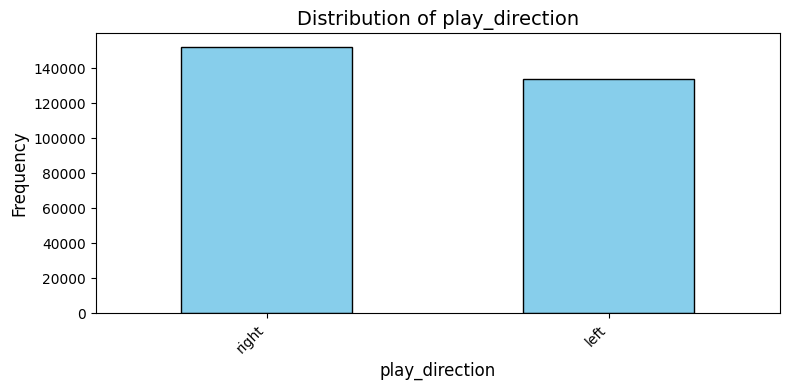

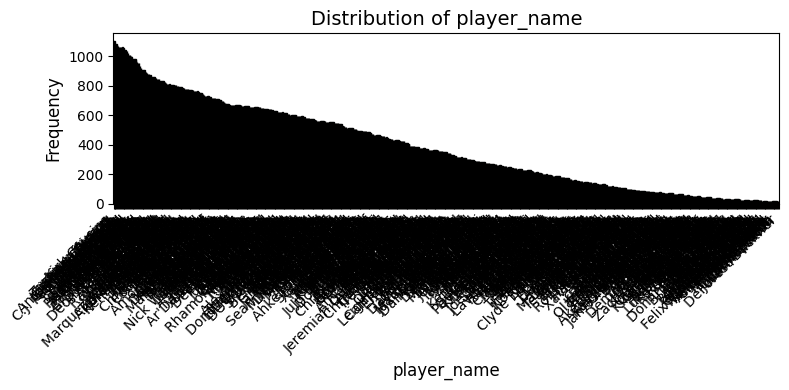

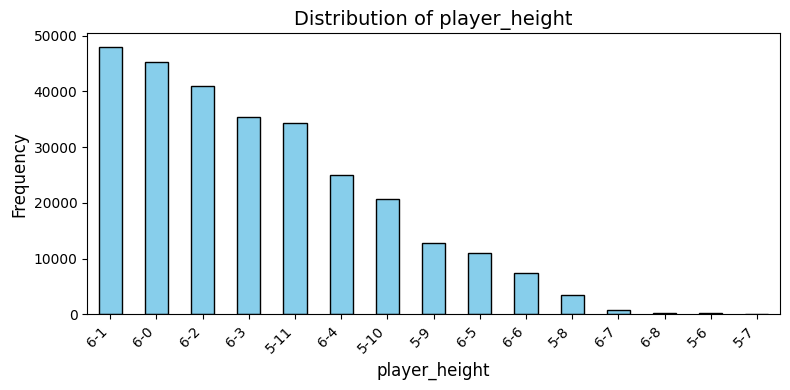

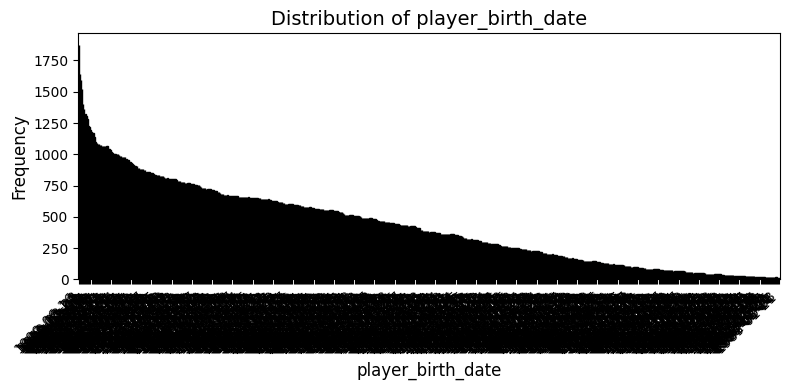

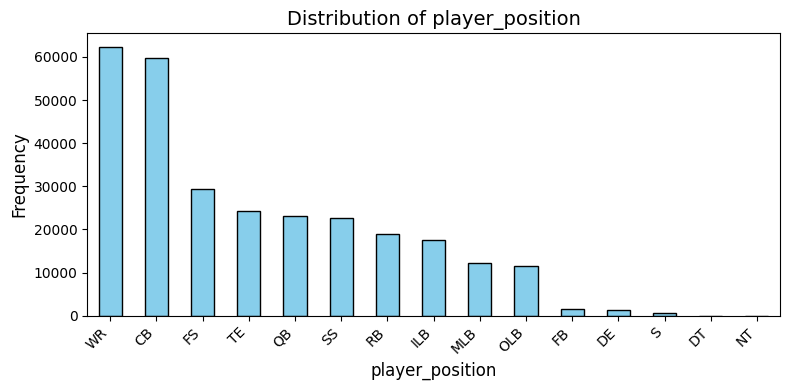

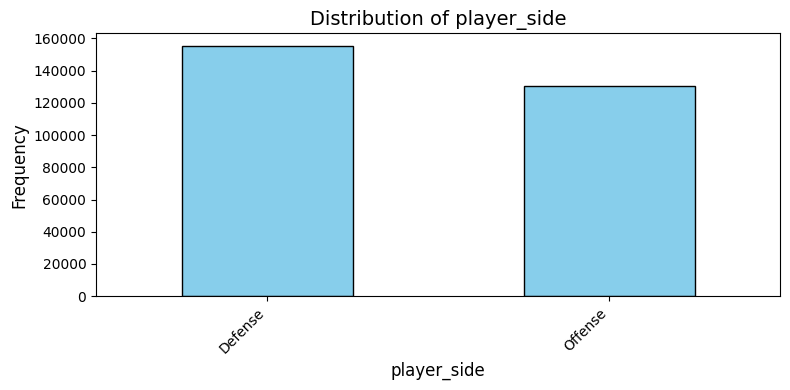

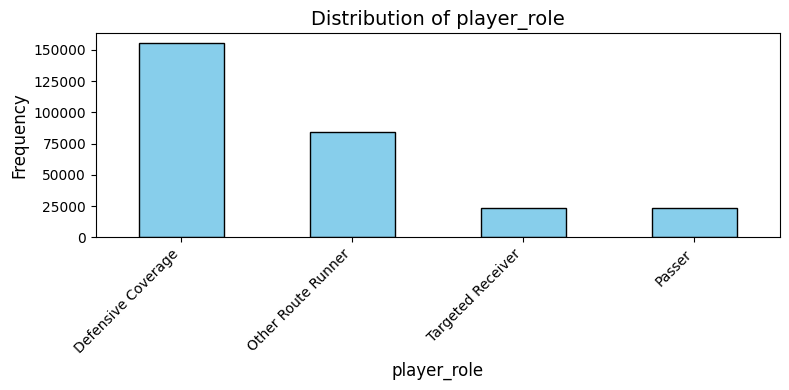

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Identificar las columnas categóricas
categorical_cols = nfl_df.select_dtypes(include='object').columns

# Crear una gráfica de barras para cada variable categórica
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    nfl_df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [18]:
# Mostrar estadísticas básicas de las variables numéricas
nfl_df.describe()


,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,2.857140e+05,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000,285714.000000
mean,2.023091e+09,2284.758118,49278.353829,16.055010,60.343049,211.784074,60.466355,26.751004,3.041966,2.126249,177.926268,181.198227,11.298669,60.851685,26.215487
std,8.575269e+01,1239.145629,5173.118005,10.689869,23.534325,21.965350,24.007917,10.035753,2.231126,1.430355,100.934248,98.972312,5.727945,25.759902,15.275341
min,2.023091e+09,55.000000,34452.000000,1.000000,11.000000,153.000000,1.210000,0.970000,0.000000,0.000000,0.000000,0.000000,5.000000,1.330000,-1.690000
25%,2.023091e+09,1232.000000,44995.000000,8.000000,40.000000,195.000000,41.630000,18.900000,1.120000,1.010000,89.530000,89.930000,8.000000,41.730000,12.640000
50%,2.023091e+09,2263.000000,48456.000000,15.000000,59.000000,208.000000,58.810000,26.710000,2.730000,1.920000,173.365000,182.230000,10.000000,59.060001,25.450001
75%,2.023091e+09,3302.000000,53609.000000,23.000000,79.000000,226.000000,78.520000,34.530000,4.650000,3.050000,269.580000,271.320000,13.000000,78.970001,39.250000
max,2.023091e+09,4699.000000,56663.000000,74.000000,109.000000,347.000000,119.860000,52.430000,12.530000,17.120000,359.990000,359.990000,94.000000,119.779999,57.330002


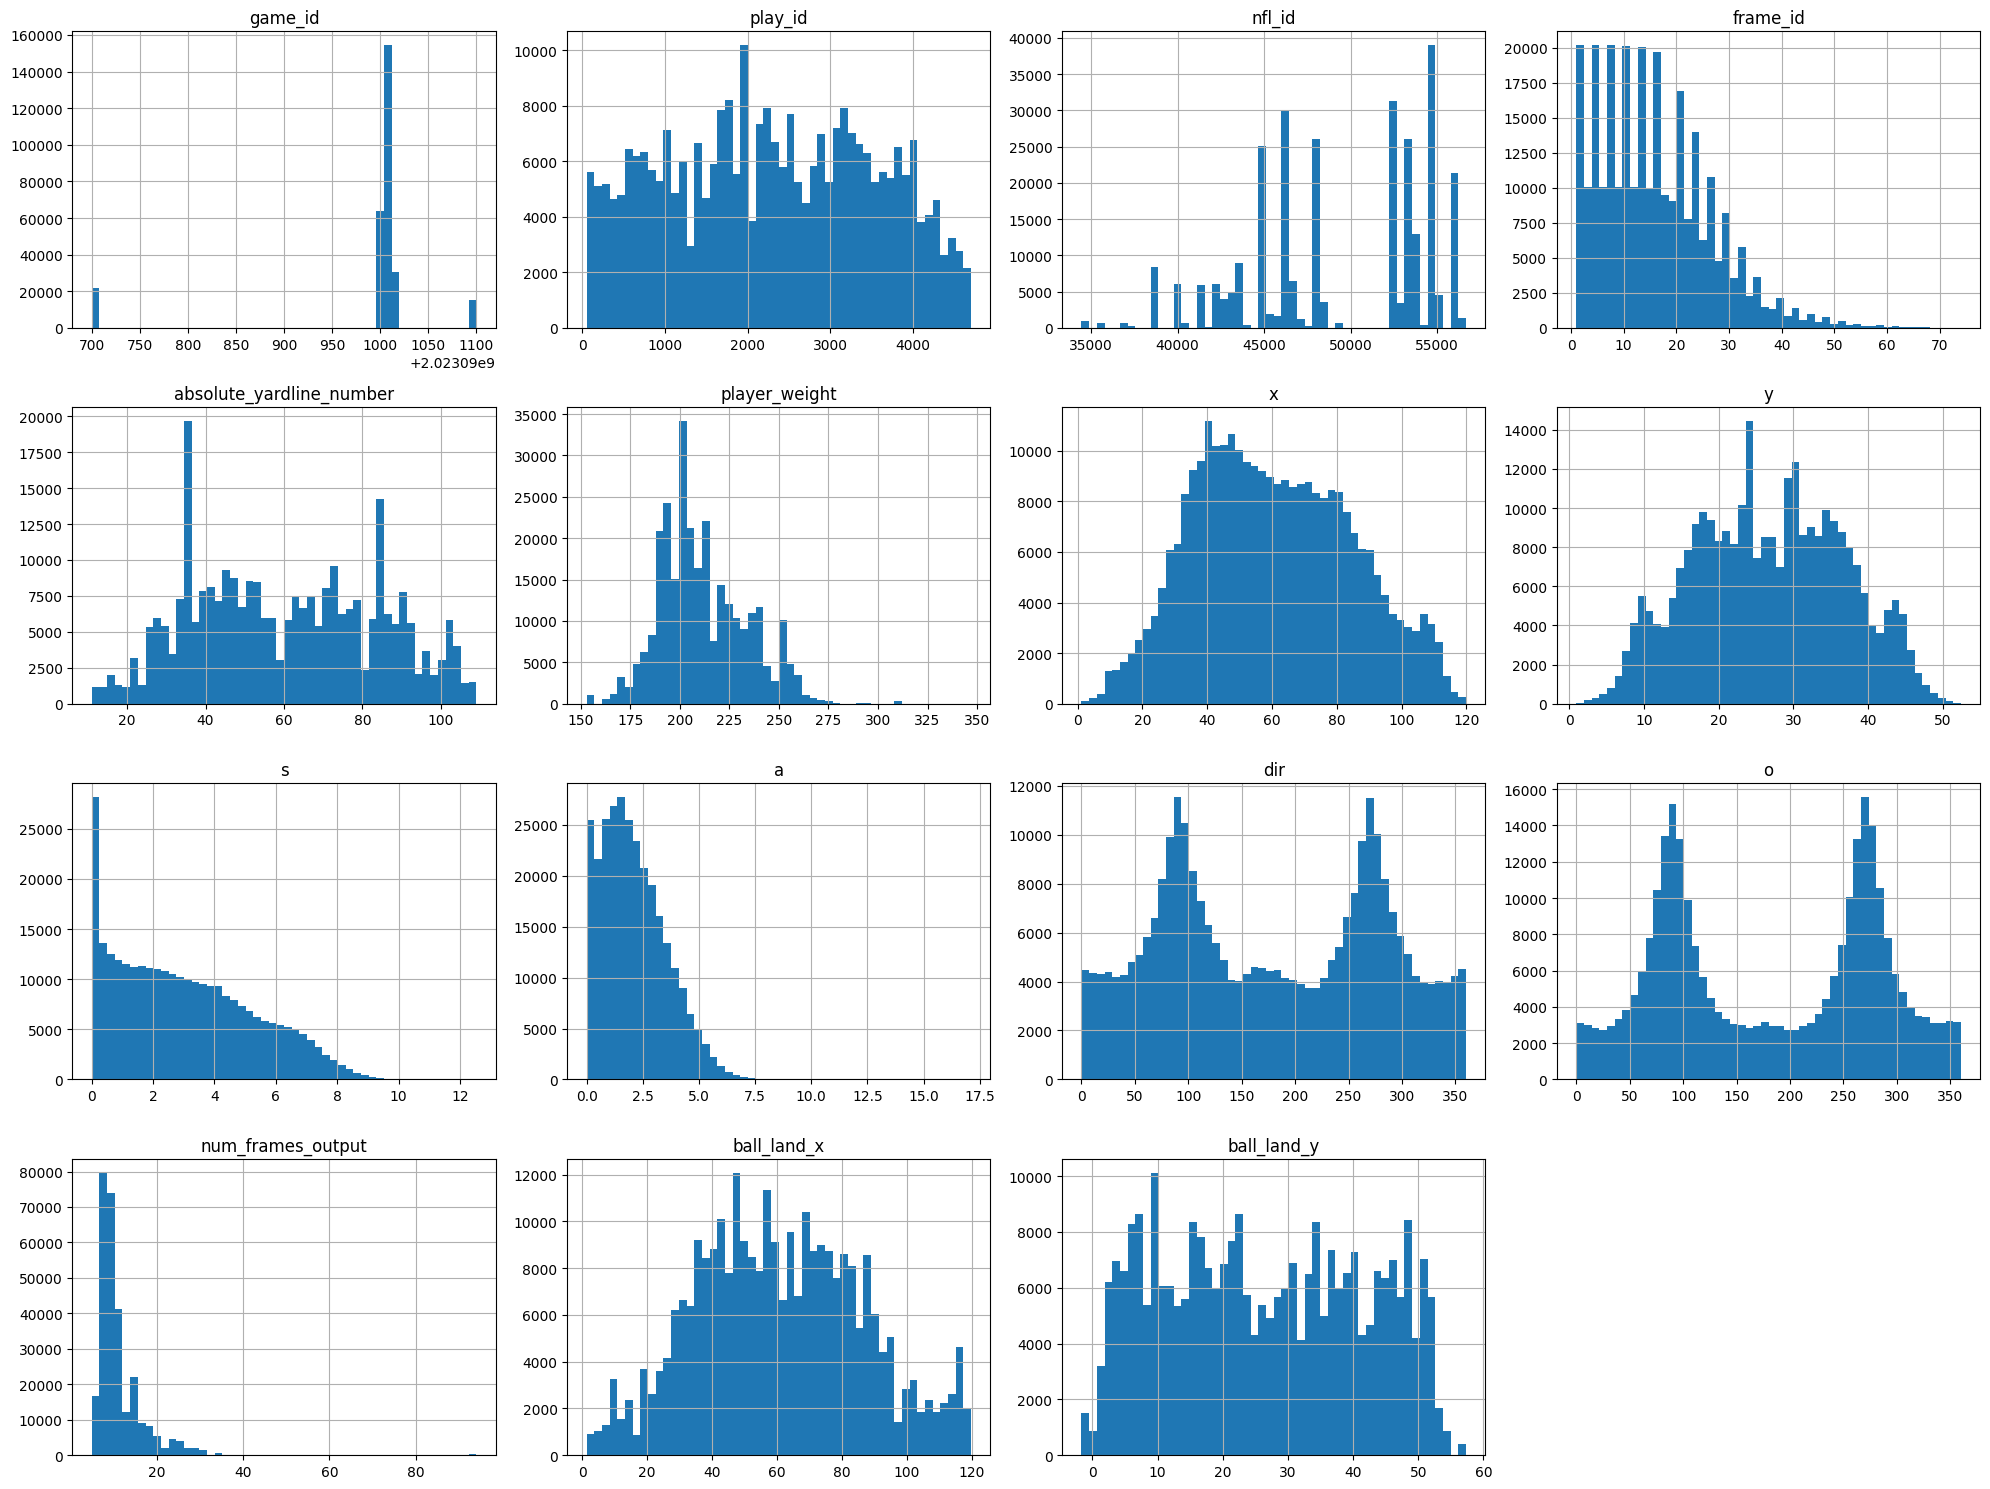

In [19]:
import matplotlib.pyplot as plt

# Crear histogramas de todas las características numéricas del dataset NFL
nfl_df.hist(bins=50, figsize=(20,15))

plt.tight_layout()  # Ajusta los espacios entre subgráficos
plt.savefig('results/nfl_attribute_histogram_plots.pdf', format='pdf', dpi=300)  # Guarda los histogramas en PDF
plt.show()  # Muestra las gráficas


### **Preparacion de Datos**

In [20]:
# ============================================================
#  PREPARACIÓN DE VARIABLES CATEGÓRICAS - NFL DATASET
# ============================================================

import pandas as pd
from datetime import datetime

# Variables categóricas del dataset
categoricas = ['play_direction', 'player_name', 'player_height',
               'player_birth_date', 'player_position', 'player_side', 'player_role']

# ------------------------------------------------------------
# Convertir altura "6-2" a pulgadas totales (numérico)
# ------------------------------------------------------------
nfl_df['player_height_inches'] = nfl_df['player_height'].apply(
    lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]) if isinstance(x, str) and '-' in x else None
)

# ------------------------------------------------------------
# Convertir fecha de nacimiento a edad actual (numérico)
# ------------------------------------------------------------
current_year = datetime.now().year
nfl_df['player_age'] = nfl_df['player_birth_date'].apply(
    lambda d: current_year - int(d.split('-')[0]) if isinstance(d, str) and '-' in d else None
)

# ------------------------------------------------------------
# Codificar nombre del jugador como número
# ------------------------------------------------------------
nfl_df['player_name_code'] = nfl_df['player_name'].astype('category').cat.codes

# ------------------------------------------------------------
# Aplicar One-Hot Encoding a variables categóricas puras
# ------------------------------------------------------------
categoricas_puras = ['play_direction', 'player_position', 'player_side', 'player_role']
nfl_encoded = pd.get_dummies(nfl_df, columns=categoricas_puras, drop_first=False)

# ------------------------------------------------------------
# Eliminar columnas originales redundantes (object)
# ------------------------------------------------------------
cols_a_eliminar = ['player_name', 'player_height', 'player_birth_date']
nfl_clean = nfl_encoded.drop(columns=cols_a_eliminar)

# ------------------------------------------------------------
# Verificar estructura final del DataFrame limpio
# ------------------------------------------------------------
print("\n Dataset transformado y limpio correctamente. Vista general:\n")
print(nfl_clean.info())


# ------------------------------------------------------------
# Confirmar que no quedan columnas tipo 'object'
# ------------------------------------------------------------
print("\n Tipos de datos restantes:")
print(nfl_clean.dtypes.value_counts())



 Dataset transformado y limpio correctamente. Vista general:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285714 entries, 0 to 285713
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   game_id                         285714 non-null  int64  
 1   play_id                         285714 non-null  int64  
 2   player_to_predict               285714 non-null  bool   
 3   nfl_id                          285714 non-null  int64  
 4   frame_id                        285714 non-null  int64  
 5   absolute_yardline_number        285714 non-null  int64  
 6   player_weight                   285714 non-null  int64  
 7   x                               285714 non-null  float64
 8   y                               285714 non-null  float64
 9   s                               285714 non-null  float64
 10  a                               285714 non-null  float64
 11  dir            

In [21]:
# ============================================================
#  PARTICIÓN HOLD-OUT (60/20/20) - NFL DATASET
# ============================================================

from sklearn.model_selection import train_test_split
import pandas as pd

# ------------------------------------------------------------
#  Separar variables predictoras (X) y objetivo (Y)
# ------------------------------------------------------------
X = nfl_encoded.drop(columns=['x', 'y'])
y = nfl_encoded[['x', 'y']]

# ------------------------------------------------------------
#  División inicial: 60% entrenamiento, 40% temporal
# ------------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# ------------------------------------------------------------
#  Del 40% restante → 20% validación y 20% test
# ------------------------------------------------------------
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# ------------------------------------------------------------
#  Mostrar tamaños para verificar proporciones
# ------------------------------------------------------------
print("✅ Tamaño del conjunto de entrenamiento:", X_train.shape)
print("✅ Tamaño del conjunto de validación:", X_valid.shape)
print("✅ Tamaño del conjunto de prueba:", X_test.shape)

# ------------------------------------------------------------
#  Mostrar ejemplos de los tres conjuntos
# ------------------------------------------------------------
print("\n🔹 Vista de los datos de entrenamiento:")
display(X_train.head())

print("\n🔹 Vista de los datos de validación:")
display(X_valid.head())

print("\n🔹 Vista de los datos de prueba:")
display(X_test.head())


✅ Tamaño del conjunto de entrenamiento: (171428, 43)
✅ Tamaño del conjunto de validación: (57143, 43)
✅ Tamaño del conjunto de prueba: (57143, 43)

🔹 Vista de los datos de entrenamiento:


,game_id,play_id,player_to_predict,nfl_id,frame_id,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,...,player_position_S,player_position_SS,player_position_TE,player_position_WR,player_side_Defense,player_side_Offense,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
134953,2023091006,2861,False,44820,18,93,Christian McCaffrey,5-11,205,1996-06-07,...,False,False,False,False,False,True,False,True,False,False
94969,2023091004,1958,False,47791,2,27,T.J. Hockenson,6-5,248,1997-07-03,...,False,False,True,False,False,True,False,True,False,False
108661,2023091005,721,False,54483,28,67,Treylon Burks,6-3,225,2000-03-23,...,False,False,False,True,False,True,False,True,False,False
71642,2023091003,1649,False,54980,5,55,Dallis Flowers,6-2,190,1997-06-04,...,False,False,False,False,True,False,True,False,False,False
124294,2023091006,282,False,46698,21,18,Levi Wallace,6-0,179,1995-06-12,...,False,False,False,False,True,False,True,False,False,False



🔹 Vista de los datos de validación:


,game_id,play_id,player_to_predict,nfl_id,frame_id,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,...,player_position_S,player_position_SS,player_position_TE,player_position_WR,player_side_Defense,player_side_Offense,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
208386,2023091010,2284,False,52520,19,76,Joshua Kelley,5-11,219,1997-11-20,...,False,False,False,False,False,True,False,True,False,False
281110,2023091100,2536,False,44976,9,43,Matt Milano,6-0,223,1994-07-28,...,False,False,False,False,True,False,True,False,False,False
64710,2023091002,3617,False,53434,12,35,Ja'Marr Chase,6-1,200,2000-03-01,...,False,False,False,True,False,True,False,True,False,False
208991,2023091010,2930,True,46086,12,78,Derwin James,6-2,215,1996-08-03,...,False,True,False,False,True,False,True,False,False,False
1646,2023090700,436,True,53541,15,31,Amon-Ra St. Brown,6-1,195,1999-10-24,...,False,False,False,True,False,True,False,False,False,True



🔹 Vista de los datos de prueba:


,game_id,play_id,player_to_predict,nfl_id,frame_id,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,...,player_position_S,player_position_SS,player_position_TE,player_position_WR,player_side_Defense,player_side_Offense,player_role_Defensive Coverage,player_role_Other Route Runner,player_role_Passer,player_role_Targeted Receiver
83989,2023091003,4333,False,44926,2,90,Rayshawn Jenkins,6-1,220,1994-01-25,...,False,True,False,False,True,False,True,False,False,False
237396,2023091011,4096,True,44862,20,99,Justin Evans,6-0,199,1995-08-26,...,False,False,False,False,True,False,True,False,False,False
51637,2023091002,319,False,42347,14,88,Amari Cooper,6-1,211,1994-06-17,...,False,False,False,True,False,True,False,True,False,False
187469,2023091009,1946,True,42361,50,15,Marcus Peters,6-0,197,1993-01-09,...,False,False,False,False,True,False,True,False,False,False
128644,2023091006,1207,False,46139,26,85,Fred Warner,6-3,236,1996-11-19,...,False,False,False,False,True,False,True,False,False,False


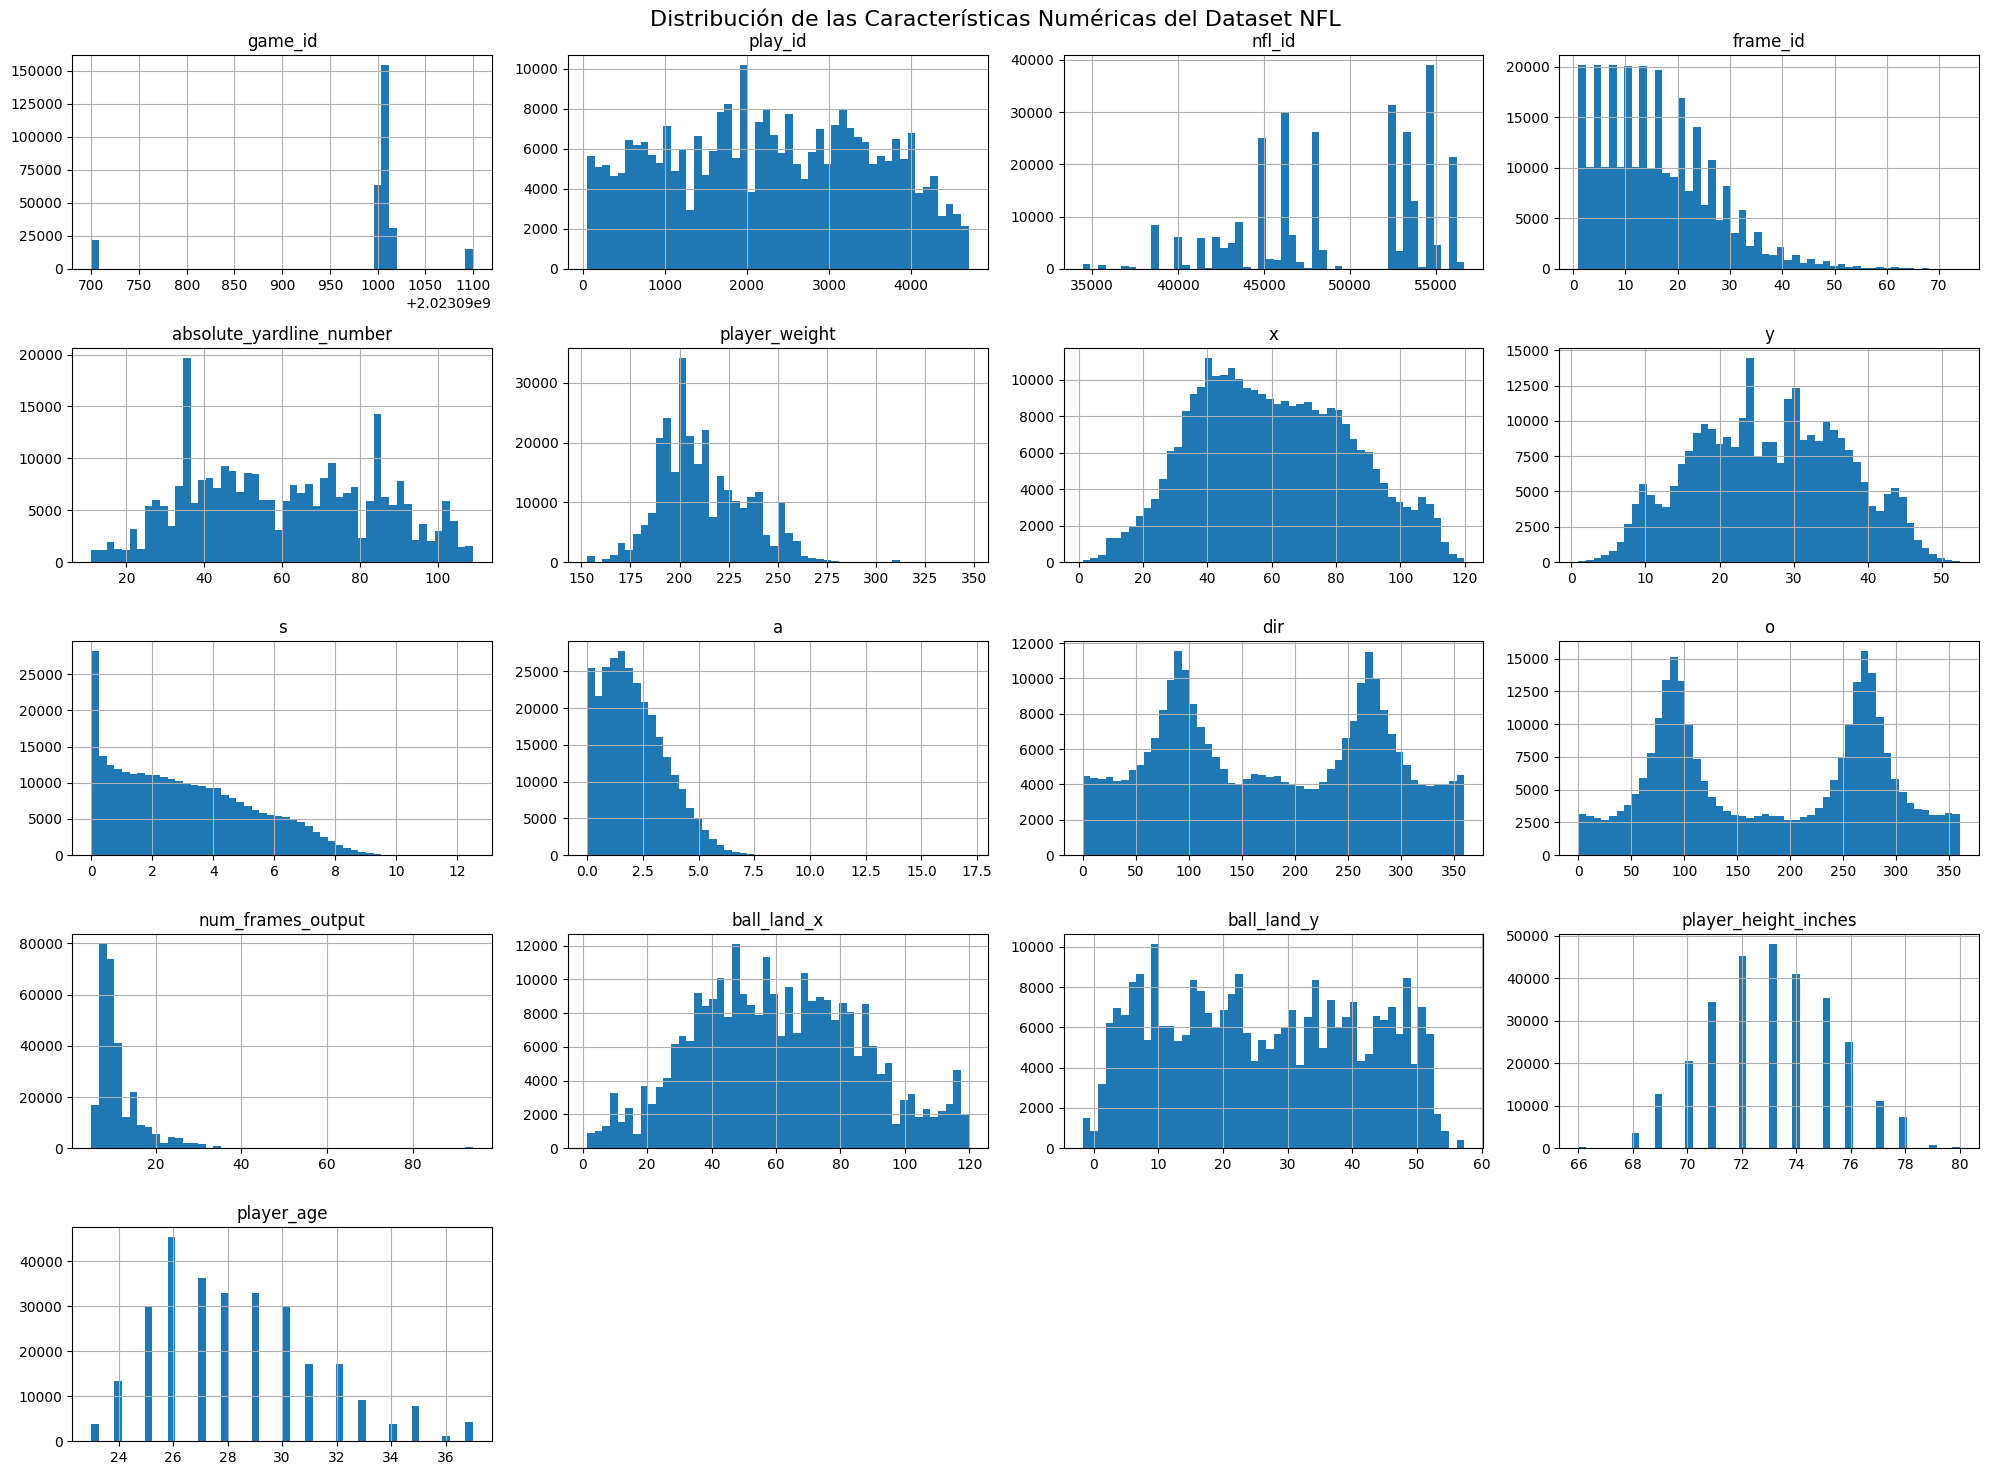

In [22]:
# ============================================================
#  HISTOGRAMAS DE TODAS LAS VARIABLES NUMÉRICAS - NFL DATASET
# ============================================================

import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas
nfl_numeric = nfl_encoded.select_dtypes(include=['int64', 'float64'])

# Generar histogramas
nfl_numeric.hist(bins=50, figsize=(20, 15))

plt.suptitle("Distribución de las Características Numéricas del Dataset NFL", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # deja espacio para el título
plt.show()


Tamaño del conjunto de entrenamiento: (171428, 43)
Columnas disponibles: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'player_height_inches', 'player_age', 'player_name_code', 'play_direction_left', 'play_direction_right', 'player_position_CB', 'player_position_DE', 'player_position_DT', 'player_position_FB', 'player_position_FS', 'player_position_ILB', 'player_position_MLB', 'player_position_NT', 'player_position_OLB', 'player_position_QB', 'player_position_RB', 'player_position_S', 'player_position_SS', 'player_position_TE', 'player_position_WR', 'player_side_Defense', 'player_side_Offense', 'player_role_Defensive Coverage', 'player_role_Other Route Runner', 'player_role_Passer', 'player_role_Targeted Receiver']
⚠️ No se encontraron 'x' y 'y'. Se usarán game_id y play_id para graficar.


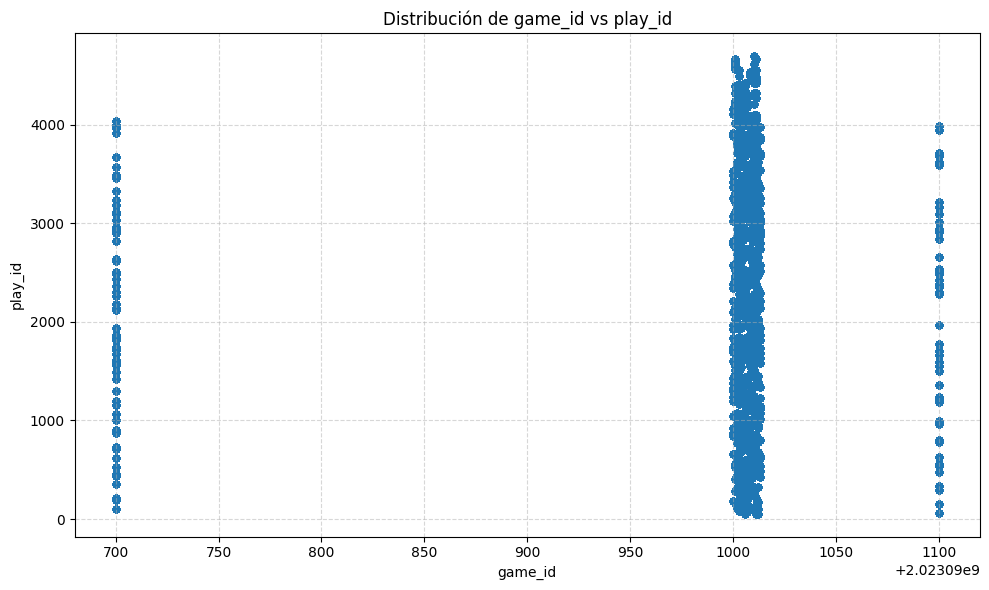

In [29]:
# ============================================================
#  MAPA DE POSICIONES EN EL CAMPO - NFL DATASET (versión adaptada)
# ============================================================

import matplotlib.pyplot as plt

# Copiar conjunto de entrenamiento (como en el ejemplo de housing)
nfl_train = strat_train_set.copy() if 'strat_train_set' in locals() else X_train.copy()

print("Tamaño del conjunto de entrenamiento:", nfl_train.shape)
print("Columnas disponibles:", nfl_train.columns.tolist())

# Verificamos si existen las columnas 'x' y 'y'
if {'x', 'y'}.issubset(nfl_train.columns):
    # Graficar posiciones reales del campo
    nfl_train.plot(
        kind="scatter",
        x="x",
        y="y",
        alpha=0.4,
        figsize=(10, 6),
        title="Distribución de posiciones de jugadores en el campo"
    )
    plt.xlabel("Posición X (longitud del campo, 0–120 yardas)")
    plt.ylabel("Posición Y (ancho del campo, 0–53.3 yardas)")
else:
    # Alternativa si no existen las columnas x/y
    num_cols = nfl_train.select_dtypes(include=['float64', 'int64']).columns
    if len(num_cols) >= 2:
        print(f"⚠️ No se encontraron 'x' y 'y'. Se usarán {num_cols[0]} y {num_cols[1]} para graficar.")
        nfl_train.plot(
            kind="scatter",
            x=num_cols[0],
            y=num_cols[1],
            alpha=0.4,
            figsize=(10, 6),
            title=f"Distribución de {num_cols[0]} vs {num_cols[1]}"
        )
        plt.xlabel(num_cols[0])
        plt.ylabel(num_cols[1])
    else:
        print("⚠️ No hay suficientes columnas numéricas para graficar.")

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('results/nfl_field_positions.pdf', format='pdf', dpi=300)
plt.show()


In [ ]:
# ============================================================
#  MAPA DE DISPERSIÓN SOBRE EL CAMPO NFL (CORREGIDO)
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

# Combinar X_train y y_train para incluir posiciones
nfl_plot = pd.concat([X_train, y_train], axis=1)

# Crear figura
fig, ax = plt.subplots(figsize=(12, 6))

# Gráfico de dispersión
scatter = ax.scatter(
    nfl_plot["x"], nfl_plot["y"],
    c=nfl_plot.get("s", 0),          # Color = velocidad (si existe)
    s=nfl_plot.get("a", 1) * 5,      # Tamaño = aceleración (si existe)
    cmap=plt.get_cmap("jet"),
    alpha=0.6,
    label="Jugadores"
)

# Etiquetas y límites
ax.set_xlim(0, 120)
ax.set_ylim(0, 53.3)
ax.set_xlabel("Posición X (longitud del campo)", fontsize=12)
ax.set_ylabel("Posición Y (ancho del campo)", fontsize=12)
ax.set_title("Mapa de Posiciones y Velocidades de Jugadores - NFL Dataset", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.4)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Velocidad del jugador (s)', fontsize=12)

# Mostrar y guardar
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('results/nfl_field_scatter_map.pdf', format='pdf', dpi=300)
plt.show()


In [ ]:
# ============================================================
#  MATRIZ DE CORRELACIÓN - NFL DATASET
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear copia del dataset de entrenamiento combinado
nfl_corr = pd.concat([X_train, y_train], axis=1).copy()

# Eliminar columnas no numéricas (object o boolean)
nfl_corr = nfl_corr.select_dtypes(include=[np.number])

# Calcular matriz de correlación
corr_matrix = nfl_corr.corr()

# Visualización en forma de tabla coloreada
corr_matrix.style.background_gradient(cmap='coolwarm')


In [ ]:
# ============================================================
# 🔗 MATRIZ DE CORRELACIÓN - NFL DATASET (HEATMAP)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Crear copia del dataset principal
nfl_data = nfl_encoded.copy()

# Seleccionar solo columnas numéricas (para evitar errores con variables categóricas codificadas)
nfl_data_num = nfl_data.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = nfl_data_num.corr()

# Graficar el mapa de calor
plt.figure(figsize=(7, 7))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,  # Cambia a True si quieres ver los valores numéricos
    xticklabels=corr_matrix.columns.values,
    yticklabels=corr_matrix.columns.values
)

plt.title("Matriz de correlación - Dataset NFL", fontsize=16)
plt.tight_layout()
plt.savefig('results/nfl_corr_matrix.pdf', format='pdf', dpi=300)
plt.show()


In [ ]:
# ============================================================
#  CORRELACIÓN ORDENADA CON VARIABLES OBJETIVO (x, y)
# ============================================================

# Crear copia de los datos
nfl_data = nfl_encoded.copy()

# Seleccionar solo columnas numéricas
nfl_data_num = nfl_data.select_dtypes(include=['number'])

# Calcular matriz de correlación
corr_matrix = nfl_data_num.corr()

# ------------------------------------------------------------
# Mostrar correlaciones ordenadas respecto a la variable 'x'
# ------------------------------------------------------------
print(" Correlaciones con la variable objetivo 'x':")
corr_x = corr_matrix["x"].sort_values(ascending=False)
display(corr_x.to_frame().style.background_gradient(cmap='coolwarm'))

# ------------------------------------------------------------
# Mostrar correlaciones ordenadas respecto a la variable 'y'
# ------------------------------------------------------------
print("\n Correlaciones con la variable objetivo 'y':")
corr_y = corr_matrix["y"].sort_values(ascending=False)
display(corr_y.to_frame().style.background_gradient(cmap='coolwarm'))


In [ ]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# ------------------------------------------------------------
#  Tomar una muestra representativa (reduce carga computacional)
# ------------------------------------------------------------
nfl_sample = nfl_encoded.sample(2000, random_state=42)

# Seleccionar las variables más relevantes
attributes = ["x", "y", "s", "a", "o", "dir"]

# Graficar la matriz de dispersión
scatter_matrix(nfl_sample[attributes], figsize=(10, 8), alpha=0.5)

plt.suptitle("Matriz de dispersión (muestra de 2000 registros NFL)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
#  INGENIERÍA DE CARACTERÍSTICAS - NFL DATASET
# ============================================================

import numpy as np

# ------------------------------------------------------------
#  Copiamos el dataset de trabajo
# ------------------------------------------------------------
# Se trabaja sobre una copia para no modificar el DataFrame original.
nfl_features = nfl_encoded.copy()

# ------------------------------------------------------------
#  Velocidad resultante (componentes en eje X y Y)
# ------------------------------------------------------------
# Se descompone la velocidad total (s) en componentes horizontales (vx) y verticales (vy)
# usando trigonometría con el ángulo de dirección (dir, en grados).
nfl_features['vx'] = nfl_features['s'] * np.cos(np.deg2rad(nfl_features['dir']))
nfl_features['vy'] = nfl_features['s'] * np.sin(np.deg2rad(nfl_features['dir']))

# ------------------------------------------------------------
#  Distancia al punto donde aterriza el balón
# ------------------------------------------------------------
# Calcula la distancia euclidiana entre la posición actual del jugador (x, y)
# y el punto donde se espera que caiga el balón (ball_land_x, ball_land_y).
nfl_features['distance_to_ball_land'] = np.sqrt(
    (nfl_features['x'] - nfl_features['ball_land_x'])**2 +
    (nfl_features['y'] - nfl_features['ball_land_y'])**2
)

# ------------------------------------------------------------
#  Relación aceleración / velocidad
# ------------------------------------------------------------
# Indica qué tanto cambia la velocidad de un jugador.
# Se agrega un pequeño valor (1e-3) para evitar divisiones por cero.
nfl_features['acceleration_ratio'] = nfl_features['a'] / (nfl_features['s'] + 1e-3)

# ------------------------------------------------------------
#  Edad normalizada
# ------------------------------------------------------------
# Escala la edad del jugador para representar su desviación estándar respecto al promedio.
nfl_features['age_scaled'] = (
    nfl_features['player_age'] - nfl_features['player_age'].mean()
) / nfl_features['player_age'].std()

# ------------------------------------------------------------
#  Relación peso / altura
# ------------------------------------------------------------
# Representa la densidad física del jugador (cuánto pesa por unidad de altura).
nfl_features['weight_height_ratio'] = (
    nfl_features['player_weight'] / (nfl_features['player_height_inches'] + 1e-3)
)

# ------------------------------------------------------------
#  Velocidad horizontal (solo eje X)
# ------------------------------------------------------------
# Magnitud de la velocidad en el eje horizontal, útil para ver desplazamiento lateral.
nfl_features['horizontal_speed'] = np.abs(nfl_features['vx'])

# ------------------------------------------------------------
#  Visualización de las nuevas características creadas
# ------------------------------------------------------------
new_features = [
    'vx', 'vy', 'distance_to_ball_land', 'acceleration_ratio',
    'age_scaled', 'weight_height_ratio', 'horizontal_speed'
]

print("\n Nuevas características creadas:\n")
display(nfl_features[new_features].head())


In [ ]:
# ============================================================
#  MATRIZ DE CORRELACIÓN - NFL DATASET (con nuevas variables)
# ============================================================

# Calculamos la matriz de correlación entre todas las variables numéricas
corr_matrix = nfl_features.corr(numeric_only=True)

# ------------------------------------------------------------
# Variables objetivo: posición del jugador en el campo (x e y)
# ------------------------------------------------------------
target_variables = ['x', 'y']

for target in target_variables:
    print(f"\n📊 Correlaciones con la variable objetivo '{target}':\n")

    # Ordenar correlaciones de mayor a menor respecto a la variable elegida
    corr_sorted = corr_matrix[target].sort_values(ascending=False)

    # Mostrar resultados en formato tabla con gradiente de color
    display(corr_sorted.to_frame().style.background_gradient(cmap='coolwarm'))


In [ ]:
# ============================================================
#  1) SEPARAR ENTRADAS Y SALIDAS (igual al ejemplo adaptado)
# ============================================================

# Suponemos que ya ejecutaste el bloque de ingeniería y que existe nfl_features
# (copia con nuevas columnas: vx, vy, distance_to_ball_land, etc.)
# Si no existe, reemplaza 'nfl_features' por 'nfl_encoded' o el DataFrame correcto.

# 1.1) Eliminar variables objetivo ('x' y 'y') de las entradas
X = nfl_features.drop(columns=['x', 'y'])  # entradas (features)

# 1.2) Guardar las etiquetas (targets) por separado
y_labels = nfl_features[['x', 'y']].copy()  # etiquetas (targets)

# Mostrar confirmación
print("X (entradas) shape:", X.shape)
print("y_labels (etiquetas) shape:", y_labels.shape)

# ============================================================
#  2) COMPROBAR FILAS CON ALGÚN VALOR NULO (igual al ejemplo)
# ============================================================

# Devuelve un Series booleano: True si la fila tiene al menos un NaN en X
rows_with_any_null = X.isnull().any(axis=1)

# Mostrar las primeras filas del booleano (igual que el ejemplo)
print("\n¿Alguna columna con NaN por fila? (primeras 5 filas):")
display(rows_with_any_null.head())

# Si quieres ver las filas completas que tienen algún NaN (opcional),
# puedes ejecutar (comentado para seguir exactamente el ejemplo original):
# sample_incomplete_rows = X[rows_with_any_null].head()
# display(sample_incomplete_rows)


In [ ]:
# ============================
#  Dependencias
# ============================
import numpy as np
import pandas as pd
import math
import time
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# Modelos
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Optuna
!pip install optuna --quiet
import optuna

# Para warnings (opcional)
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# ----------------------------
#  Assumptions:
#  - 'nfl_features' es el DataFrame final con nuevas features, y con columnas 'x' y 'y' (targets).
#  - si usas otro DataFrame, reemplázalo.
# ----------------------------

# reproducibilidad
RANDOM_STATE = 42

# lista de play_id únicos, shuffle y split 60/20/20
plays = nfl_features['play_id'].unique()
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(plays)

n = len(plays)
n_train = int(0.60 * n)
n_val = int(0.20 * n)

train_plays = plays[:n_train]
val_plays   = plays[n_train:n_train + n_val]
test_plays  = plays[n_train + n_val:]

train_df = nfl_features[nfl_features['play_id'].isin(train_plays)].reset_index(drop=True)
val_df   = nfl_features[nfl_features['play_id'].isin(val_plays)].reset_index(drop=True)
test_df  = nfl_features[nfl_features['play_id'].isin(test_plays)].reset_index(drop=True)

# Separar X,y
FEATURE_COLS = [c for c in nfl_features.columns if c not in ['x','y']]
X_train = train_df[FEATURE_COLS].copy()
y_train = train_df[['x','y']].copy()
X_valid = val_df[FEATURE_COLS].copy()
y_valid = val_df[['x','y']].copy()
X_test  = test_df[FEATURE_COLS].copy()
y_test  = test_df[['x','y']].copy()

print("Shapes:")
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_valid", X_valid.shape, "y_valid", y_valid.shape)
print("X_test ", X_test.shape,  "y_test",  y_test.shape)


In [ ]:
def mape(y_true, y_pred, eps=1e-6):
    # Mean Absolute Percentage Error (evitando division por cero)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

def evaluate_regressor_multi(model, X, y):
    """Recibe modelo (wrapper MultiOutputRegressor / pipeline), X, y (DataFrame con x,y).
       Devuelve diccionario con MAE (media sobre coordenadas), MSE, R2 y MAPE (en %)."""
    y_pred = model.predict(X)
    # y and y_pred shape (n_samples, 2)
    mae_x = mean_absolute_error(y[:,0], y_pred[:,0])
    mae_y = mean_absolute_error(y[:,1], y_pred[:,1])
    mse_x = mean_squared_error(y[:,0], y_pred[:,0])
    mse_y = mean_squared_error(y[:,1], y_pred[:,1])
    r2_x  = r2_score(y[:,0], y_pred[:,0])
    r2_y  = r2_score(y[:,1], y_pred[:,1])
    mape_x = mape(y[:,0], y_pred[:,0])
    mape_y = mape(y[:,1], y_pred[:,1])
    return {
        'MAE_x': mae_x, 'MAE_y': mae_y, 'MAE_mean': (mae_x + mae_y)/2,
        'MSE_x': mse_x, 'MSE_y': mse_y, 'MSE_mean': (mse_x + mse_y)/2,
        'R2_x': r2_x, 'R2_y': r2_y, 'R2_mean': (r2_x + r2_y)/2,
        'MAPE_x': mape_x, 'MAPE_y': mape_y, 'MAPE_mean': (mape_x + mape_y)/2
    }


In [ ]:
# ============================
# Utility: check if model needs scaling
# ============================
scale_models = {
    'LinearRegression': True,
    'Lasso': True,
    'ElasticNet': True,
    'KernelRidge': True,
    'SGDRegressor': True,
    'BayesianRidge': True,
    'GaussianProcessRegressor': True,
    'SVR': True,
    'RandomForest': False,
    'GradientBoosting': False,
    'XGBoost': False
}

# ============================
# function to build pipeline given base estimator
# ============================
from sklearn.compose import TransformedTargetRegressor

def make_pipeline_for(estimator_name, estimator_obj):
    """
    Returns pipeline that imputes missing (median) and scales if needed.
    Wraps estimator in MultiOutputRegressor to handle (x,y) multioutput.
    """
    steps = []
    # impute numeric NaNs
    steps.append(('imputer', SimpleImputer(strategy='median')))
    if scale_models.get(estimator_name, True):
        steps.append(('scaler', StandardScaler()))
    # model
    # Many scikit estimators cannot natively output multioutput; wrap later
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline(steps + [('model', estimator_obj)])
    # Use TransformedTargetRegressor with MultiOutputRegressor? simpler: MultiOutputRegressor outside.
    return pipeline

# ============================
# Objective templates for Optuna (return best model)
# ============================
def tune_model_with_optuna(model_name, X_tr, y_tr, X_val, y_val, n_trials=40, random_state=42):
    """
    tunes model hyperparams using optuna and returns fitted best model (MultiOutputRegressor pipeline).
    y_tr, y_val are dataframes with columns ['x','y'].
    """
    # convert to numpy arrays for scoring
    y_tr_arr = y_tr.values
    y_val_arr = y_val.values

    def objective(trial):
        # build estimator based on model_name and trial suggestions
        if model_name == 'LinearRegression':
            # no hyperparams, directly fit baseline
            base = LinearRegression()
        elif model_name == 'Lasso':
            alpha = trial.suggest_float('alpha', 1e-6, 10.0, log=True)
            base = Lasso(alpha=alpha, random_state=random_state, max_iter=5000)
        elif model_name == 'ElasticNet':
            alpha = trial.suggest_float('alpha', 1e-6, 10.0, log=True)
            l1 = trial.suggest_float('l1_ratio', 0.0, 1.0)
            base = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=random_state, max_iter=5000)
        elif model_name == 'KernelRidge':
            alpha = trial.suggest_float('alpha', 1e-6, 10.0, log=True)
            gamma = trial.suggest_float('gamma', 1e-6, 1.0, log=True)
            base = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
        elif model_name == 'SGDRegressor':
            alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
            penalty = trial.suggest_categorical('penalty', ['l2','l1','elasticnet'])
            l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else 0.0
            base = SGDRegressor(alpha=alpha, penalty=penalty, l1_ratio=l1_ratio,
                                max_iter=10000, tol=1e-3, random_state=random_state)
        elif model_name == 'BayesianRidge':
            # small search: priors
            alpha_1 = trial.suggest_float('alpha_1', 1e-8, 1e-2, log=True)
            alpha_2 = trial.suggest_float('alpha_2', 1e-8, 1e-2, log=True)
            lambda_1 = trial.suggest_float('lambda_1', 1e-8, 1e-2, log=True)
            lambda_2 = trial.suggest_float('lambda_2', 1e-8, 1e-2, log=True)
            base = BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)
        elif model_name == 'GaussianProcessRegressor':
            alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
            length_scale = trial.suggest_float('length_scale', 1e-2, 50.0, log=True)
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale)
            base = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True)
        elif model_name == 'SVR':
            C = trial.suggest_float('C', 1e-2, 1e3, log=True)
            eps = trial.suggest_float('epsilon', 1e-4, 1.0, log=True)
            gamma = trial.suggest_float('gamma', 1e-6, 1e-0, log=True)
            base = SVR(C=C, epsilon=eps, gamma=gamma)
        elif model_name == 'RandomForest':
            n_estimators = trial.suggest_int('n_estimators', 100, 500)
            max_depth = trial.suggest_int('max_depth', 5, 50)
            max_features = trial.suggest_float('max_features', 0.2, 1.0)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
            base = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                         max_features=max_features, min_samples_leaf=min_samples_leaf,
                                         random_state=random_state, n_jobs=1)
        elif model_name == 'GradientBoosting':
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 12)
            subsample = trial.suggest_float('subsample', 0.4, 1.0)
            max_features = trial.suggest_float('max_features', 0.3, 1.0)
            base = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                                             max_depth=max_depth, subsample=subsample,
                                             max_features=max_features, random_state=random_state)
        elif model_name == 'XGBoost':
            n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 12)
            subsample = trial.suggest_float('subsample', 0.4, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.4, 1.0)
            reg_lambda = trial.suggest_float('reg_lambda', 1e-6, 100.0, log=True)
            base = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                                     max_depth=max_depth, subsample=subsample,
                                     colsample_bytree=colsample_bytree, reg_lambda=reg_lambda,
                                     random_state=random_state, tree_method='auto', n_jobs=1)
        else:
            raise ValueError("Model not implemented: " + model_name)

        # pipeline
        pipe = make_pipeline_for(model_name, base)

        # Multi-output wrapper
        multi = MultiOutputRegressor(pipe)

        # Fit on train
        multi.fit(X_tr, y_tr)

        # Predict on validation
        y_pred = multi.predict(X_val)
        # compute MAE mean over two coords
        mae_x = mean_absolute_error(y_val_arr[:,0], y_pred[:,0])
        mae_y = mean_absolute_error(y_val_arr[:,1], y_pred[:,1])
        mae_mean = 0.5*(mae_x + mae_y)
        return mae_mean

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # best model: rebuild with best params
    best_params = study.best_params
    print(f"Best params for {model_name}:", best_params)

    # Build final estimator with best params (repeat logic)
    # For simplicity, run objective once more to get base with best params:
    # (a more robust method is to create model directly from best_params)
    # We'll create mapping to build estimator with best_params:
    def build_from_params(params):
        if model_name == 'LinearRegression':
            base = LinearRegression()
        elif model_name == 'Lasso':
            base = Lasso(alpha=params['alpha'], random_state=random_state, max_iter=5000)
        elif model_name == 'ElasticNet':
            base = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], random_state=random_state, max_iter=5000)
        elif model_name == 'KernelRidge':
            base = KernelRidge(alpha=params['alpha'], kernel='rbf', gamma=params['gamma'])
        elif model_name == 'SGDRegressor':
            penalty = params.get('penalty', 'l2')
            l1_ratio = params.get('l1_ratio', 0.0)
            base = SGDRegressor(alpha=params['alpha'], penalty=penalty, l1_ratio=l1_ratio, max_iter=10000, tol=1e-3, random_state=random_state)
        elif model_name == 'BayesianRidge':
            base = BayesianRidge(alpha_1=params['alpha_1'], alpha_2=params['alpha_2'], lambda_1=params['lambda_1'], lambda_2=params['lambda_2'])
        elif model_name == 'GaussianProcessRegressor':
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=params['length_scale'])
            base = GaussianProcessRegressor(kernel=kernel, alpha=params['alpha'], normalize_y=True)
        elif model_name == 'SVR':
            base = SVR(C=params['C'], epsilon=params['epsilon'], gamma=params['gamma'])
        elif model_name == 'RandomForest':
            base = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'],
                                         max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'],
                                         random_state=random_state, n_jobs=1)
        elif model_name == 'GradientBoosting':
            base = GradientBoostingRegressor(n_estimators=params['n_estimators'], learning_rate=params['learning_rate'],
                                             max_depth=params['max_depth'], subsample=params['subsample'],
                                             max_features=params['max_features'], random_state=random_state)
        elif model_name == 'XGBoost':
            base = xgb.XGBRegressor(n_estimators=params['n_estimators'], learning_rate=params['learning_rate'],
                                     max_depth=params['max_depth'], subsample=params['subsample'],
                                     colsample_bytree=params['colsample_bytree'], reg_lambda=params['reg_lambda'],
                                     random_state=random_state, tree_method='auto', n_jobs=1)
        else:
            raise ValueError(model_name)
        return base

    final_base = build_from_params(study.best_params)
    final_pipe = make_pipeline_for(model_name, final_base)
    final_model = MultiOutputRegressor(final_pipe)
    # fit on train (optionally retrain on train+valid outside)
    final_model.fit(X_tr, y_tr)
    return final_model, study


In [ ]:
# ============================================================
# LIMPIEZA FINAL DE VARIABLES PARA ENTRENAMIENTO
# ============================================================

#  Eliminamos columnas no numéricas o irrelevantes para los modelos
non_numeric_cols = ['player_name', 'player_birth_date']  # puedes agregar otras si las hay
X_train = X_train.drop(columns=non_numeric_cols, errors='ignore')
X_valid = X_valid.drop(columns=non_numeric_cols, errors='ignore')
X_test  = X_test.drop(columns=non_numeric_cols, errors='ignore')

#  Verificamos que todo sea numérico
print("\nTipos de datos después de limpiar:")
print(X_train.dtypes.value_counts())

#  Verificamos si quedan nulos
print("\n¿Valores nulos en el dataset?:", X_train.isnull().any().sum())


In [ ]:
# ================================================
#  Conversión de 'player_height' (de texto a número)
# ================================================

# Función para convertir alturas tipo '6-1' a pulgadas (6 pies 1 pulgada = 73 pulgadas)
def convert_height_to_inches(value):
    """
    Convierte alturas en formato 'pies-pulgadas' (ej. '6-1') a un valor numérico en pulgadas.
    Si el valor no tiene el formato correcto, devuelve NaN.
    """
    if isinstance(value, str) and '-' in value:
        try:
            feet, inches = value.split('-')
            return int(feet) * 12 + int(inches)
        except:
            return np.nan
    return value

# Aplicar conversión a todos los subconjuntos de datos
for df in [X_train, X_valid, X_test]:
    if 'player_height' in df.columns:
        df['player_height'] = df['player_height'].apply(convert_height_to_inches)

# ================================================
#  Verificar que ya no existan valores no numéricos
# ================================================
print("\nTipos de datos después de convertir 'player_height':")
print(X_train.dtypes.value_counts())

# Mostrar algunas filas para confirmar la conversión
print("\nEjemplo de conversión de alturas:")
print(X_train[['player_height']].head())


In [ ]:
# ============================================================
#  TUNING RÁPIDO CON OPTUNA - MENOR TIEMPO DE EJECUCIÓN
# ============================================================

models_to_run = [
    'LinearRegression', 'Lasso', 'ElasticNet',
    'RandomForest', 'GradientBoosting', 'XGBoost'
]

#  Explicación:
# - Dejamos solo 6 modelos representativos (lineales, árboles y boosting)
# - Los más costosos (SVR, GaussianProcess, KernelRidge) se omiten en esta versión rápida

results = {}
n_trials = 10  #  REDUCIDO de 40 → 10 (menos iteraciones por modelo)
N_SAMPLES = 2000  #  Muestra parcial para acelerar entrenamiento

#  Si el dataset es muy grande, usamos una fracción del entrenamiento
X_sample = X_train.sample(N_SAMPLES, random_state=RANDOM_STATE) if len(X_train) > N_SAMPLES else X_train
y_sample = y_train.loc[X_sample.index]

print(f"Usando {len(X_sample)} muestras para tuning (de {len(X_train)} totales)\n")

for name in models_to_run:
    start = time.time()
    print(f"\n--- Tuning rápido de {name} ---")

    model, study = tune_model_with_optuna(
        name,
        X_sample, y_sample,
        X_valid, y_valid,
        n_trials=n_trials,
        random_state=RANDOM_STATE
    )

    elapsed = time.time() - start
    print(f" {name} finalizado en {elapsed/60:.2f} min")

    results[name] = {'model': model, 'study': study}
